<a href="https://colab.research.google.com/github/lrsonly/lrs_files/blob/main/GA_2rd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import json
import numpy as np
import matplotlib.path as mplPath
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import scipy.ndimage
import os

# hyper parameters
training_json_path = '/content/drive/MyDrive/Chromosome/chromosome_train.json'
training_image_path = '/content/drive/MyDrive/Chromosome/train' + '/'
window_size = 5
overlap_HL = 0.15
GA_factor = 1.5
if not os.path.exists(training_image_path + 'training_image_weighted'):
    os.makedirs(training_image_path + 'training_image_weighted')
weighted_image_path = training_image_path + 'training_image_weighted'

target_category_id = 1

def show_weighted_image(weighted_image, original_image):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(original_image, cmap='gray')
  axs[0].set_title('Original Image')
  axs[1].imshow(weighted_image, cmap='hot')
  axs[1].set_title('Weighted Image')
  axs[2].imshow(original_image, cmap='gray')
  axs[2].imshow(weighted_image, cmap='hot', alpha=0.5)  # alpha参数设置透明度
  axs[2].set_title('Overlay Image')
  plt.show()

def save_weighted_image(weighted_image, original_image, filename, save_dir):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(weighted_image, cmap='hot')
    axs[1].set_title('Weighted Image')
    axs[2].imshow(original_image, cmap='gray')
    axs[2].imshow(weighted_image, cmap='hot', alpha=0.5)  # alpha参数设置透明度
    axs[2].set_title('Overlay Image')

    # 保存图像到文件
    plt.savefig(os.path.join(save_dir, filename + '_weighted.png'))
    plt.close(fig)

def save_weighted_npy(weighted_image, filename, save_dir):
    # 保存NumPy数组到.npy文件
    np.save(os.path.join(save_dir, filename + '_weighted.npy'), weighted_image)

def show_weighted_images_per_instance(weighted_images, original_image):
    num_instances = len(weighted_images)
    fig, axs = plt.subplots(num_instances, 3, figsize=(15, 5*num_instances))

    for i in range(num_instances):
        axs[i, 0].imshow(original_image, cmap='gray')
        axs[i, 0].set_title('Original Image')
        axs[i, 1].imshow(weighted_images[i], cmap='hot')
        axs[i, 1].set_title('Weighted Image for Instance {}'.format(i+1))
        axs[i, 2].imshow(original_image, cmap='gray')
        axs[i, 2].imshow(weighted_images[i], cmap='hot', alpha=0.2)  # alpha参数设置透明度
        axs[i, 2].set_title('Overlay Image for Instance {}'.format(i+1))

    plt.tight_layout()
    plt.show()

def save_weighted_npy_per_instance(weighted_images, filename, save_dir, instances_ids):
    for i, weighted_image in enumerate(weighted_images):
        # 使用索引作为实例的id，生成文件名
        filename_instance = "{}.npy".format(filename, instances_ids[i])
        # 保存NumPy数组到.npy文件
        np.save(os.path.join(save_dir, filename_instance), weighted_image)

In [4]:
def find_masks(num_instances, this_image, instances_in_this_image, image_shape):
  masks_in_this_image = []
  rows, cols = image_shape
  for i in range(num_instances):
    mask = np.zeros(this_image.shape)
    mask_coordinates = np.array(instances_in_this_image[i]['segmentation']).reshape(-1, 2)
    mask_path = mplPath.Path(mask_coordinates)
    y, x = np.mgrid[:rows, :cols]
    mask[mask_path.contains_points(np.vstack((x.flatten(), y.flatten())).T).reshape(rows, cols)] = 1
    masks_in_this_image.append(mask)

  return masks_in_this_image

def find_grad_fields(instances_masks, factor):
  grad_fields = {"grad_magnitude":[], "grad_direction":[]}
  for mask in instances_masks:
    rows, cols = mask.shape
    y1, x1 = np.where(mask == 1)
    center_x, center_y = np.mean(x1), np.mean(y1)

    z = np.zeros_like(mask, dtype = float)
    for m in range(rows):
      for n in range(cols):
        z[m, n] = (m - center_y)**2 + (n - center_x)**2

    grad_y, grad_x = np.gradient(z)
    gradient_magnitude = np.sqrt(grad_y**2 + grad_x**2)
    gradient_direction = np.arctan2(grad_y, factor * grad_x)
    gradient_direction[mask==0] = -4
    grad_fields["grad_magnitude"].append(gradient_magnitude)
    grad_fields["grad_direction"].append(gradient_direction)

  return grad_fields

In [5]:
def find_GA_per_instance_original(image_info, window_size, target_category_id):
  weighted_images_original = []
  rows, cols = image_info["image_shape"]
  for ins in range(image_info["num_instances"]):
    if image_info["instances_categories"][ins] != target_category_id:
      weighted_image = np.zeros((rows, cols))
    else:
      diff_array = np.zeros((rows-window_size+1, cols-window_size+1))
      for i in range(rows-window_size+1):
        for j in range(cols-window_size+1):
          mask_window = image_info["masks"][ins][i:i+window_size, j:j+window_size]
          grad_window = image_info["grad_fields"]["grad_direction"][ins][i:i+window_size, j:j+window_size]
          if np.any(mask_window):
            diffs = []
            for k in range(image_info["num_instances"]):
              if k != ins and image_info["instances_categories"][k]==target_category_id:
                diff1 = np.std(grad_window)
                window_1D_k = grad_window.reshape(-1,)
                window_1D_k = np.delete(window_1D_k, np.where(window_1D_k==-4))
                diff2 = np.std(window_1D_k)
                diffs.append(min(diff1, diff2))
            diff_array[i,j] = np.mean(diffs)
      weighted_image = np.zeros((rows,cols))
      for i in range(rows-window_size+1):
        for j in range(cols-window_size+1):
          weighted_image[i:i+window_size, j:j+window_size] = diff_array[i,j]
    weighted_images_original.append(weighted_image)

  return weighted_images_original

def find_GA_per_instance_inter(image_info, window_size, target_category_id, weighted_images_original):
  weighted_images_inter = []
  rows, cols = image_info["image_shape"]
  for ins in range(image_info["num_instances"]):
    if image_info["instances_categories"][ins] != target_category_id:
      weighted_image = np.zeros((rows, cols))
    else:
      masks_array = np.array(image_info["masks"])
      grad_direction_array = np.array(image_info["grad_fields"]["grad_direction"])
      diff_array = np.zeros((rows-window_size+1, cols-window_size+1))
      for i in range(rows-window_size+1):
        for j in range(cols-window_size+1):
          mask_window = masks_array[:, i:i+window_size, j:j+window_size]
          grad_window = grad_direction_array[:, i:i+window_size, j:j+window_size]
          if np.any(mask_window[ins]):
            diffs = []
            for k in range(image_info["num_instances"]):
              if k != ins and image_info["instances_categories"][k]==target_category_id:
                diff1 = np.std(grad_window[k,:,:] - grad_window[ins,:,:])
                window_1D_k = grad_window[k,:,:].reshape(-1,)
                window_1D_k = np.delete(window_1D_k, np.where(window_1D_k==-4))
                window_1D_i = grad_window[ins,:,:].reshape(-1,)
                window_1D_i = np.delete(window_1D_i, np.where(window_1D_i==-4))
                con_window = np.concatenate((window_1D_k, window_1D_i))
                diff2 = np.std(con_window)
                diffs.append(min(diff1, diff2))
            diff_array[i,j] = np.mean(diffs)
      weighted_image = np.zeros((rows,cols))
      for i in range(rows-window_size+1):
        for j in range(cols-window_size+1):
          weighted_image[i:i+window_size, j:j+window_size] = diff_array[i,j]

    weighted_images_inter.append(weighted_image)

  for w in range(len(weighted_images_inter)):
    for k in range(len(weighted_images_original)):
      weighted_images_inter[w] -= weighted_images_original[k]
      weighted_images_inter[w][np.where(weighted_images_inter[w]<0)] = 0
      if k != w and np.logical_and(image_info["masks"][w], image_info["masks"][k]).any() and image_info["instances_categories"][k]==target_category_id and image_info["instances_categories"][w]==target_category_id:
        weighted_images_inter[w][np.logical_and(image_info["masks"][w], image_info["masks"][k])] += 0.1
    influence = image_info["grad_fields"]["grad_magnitude"][w]
    influence = influence / np.max(influence)
    weighted_images_inter[w] *= influence
    weighted_images_inter[w] = (weighted_images_inter[w] / (np.max(weighted_images_inter[w])+1e-7))*GA_factor + 1

  return weighted_images_inter





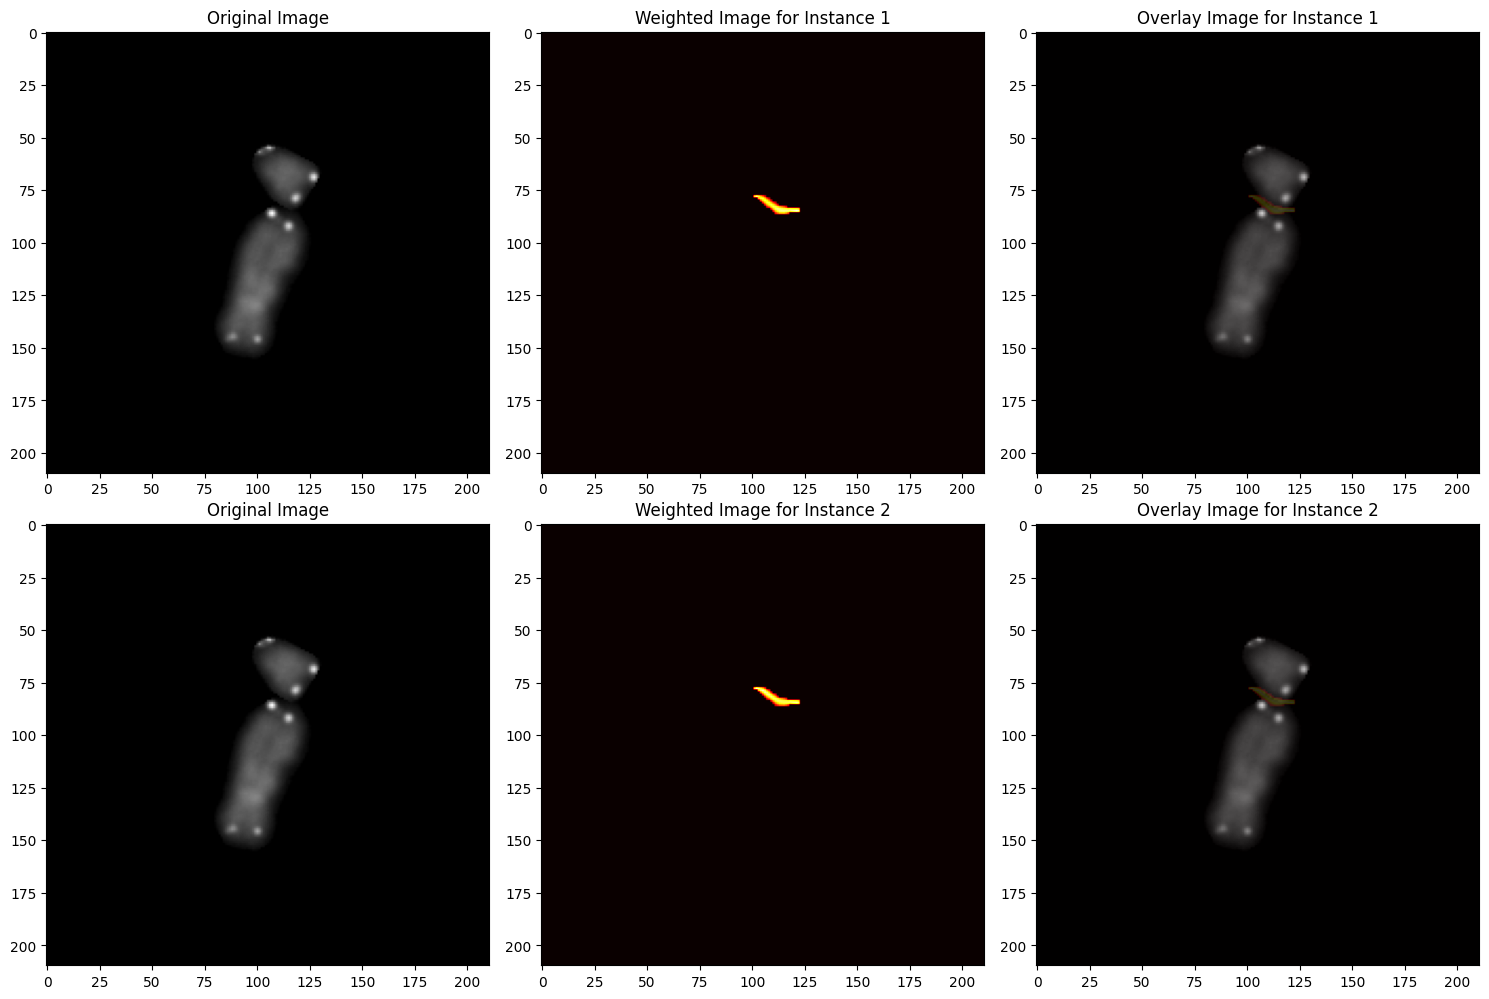

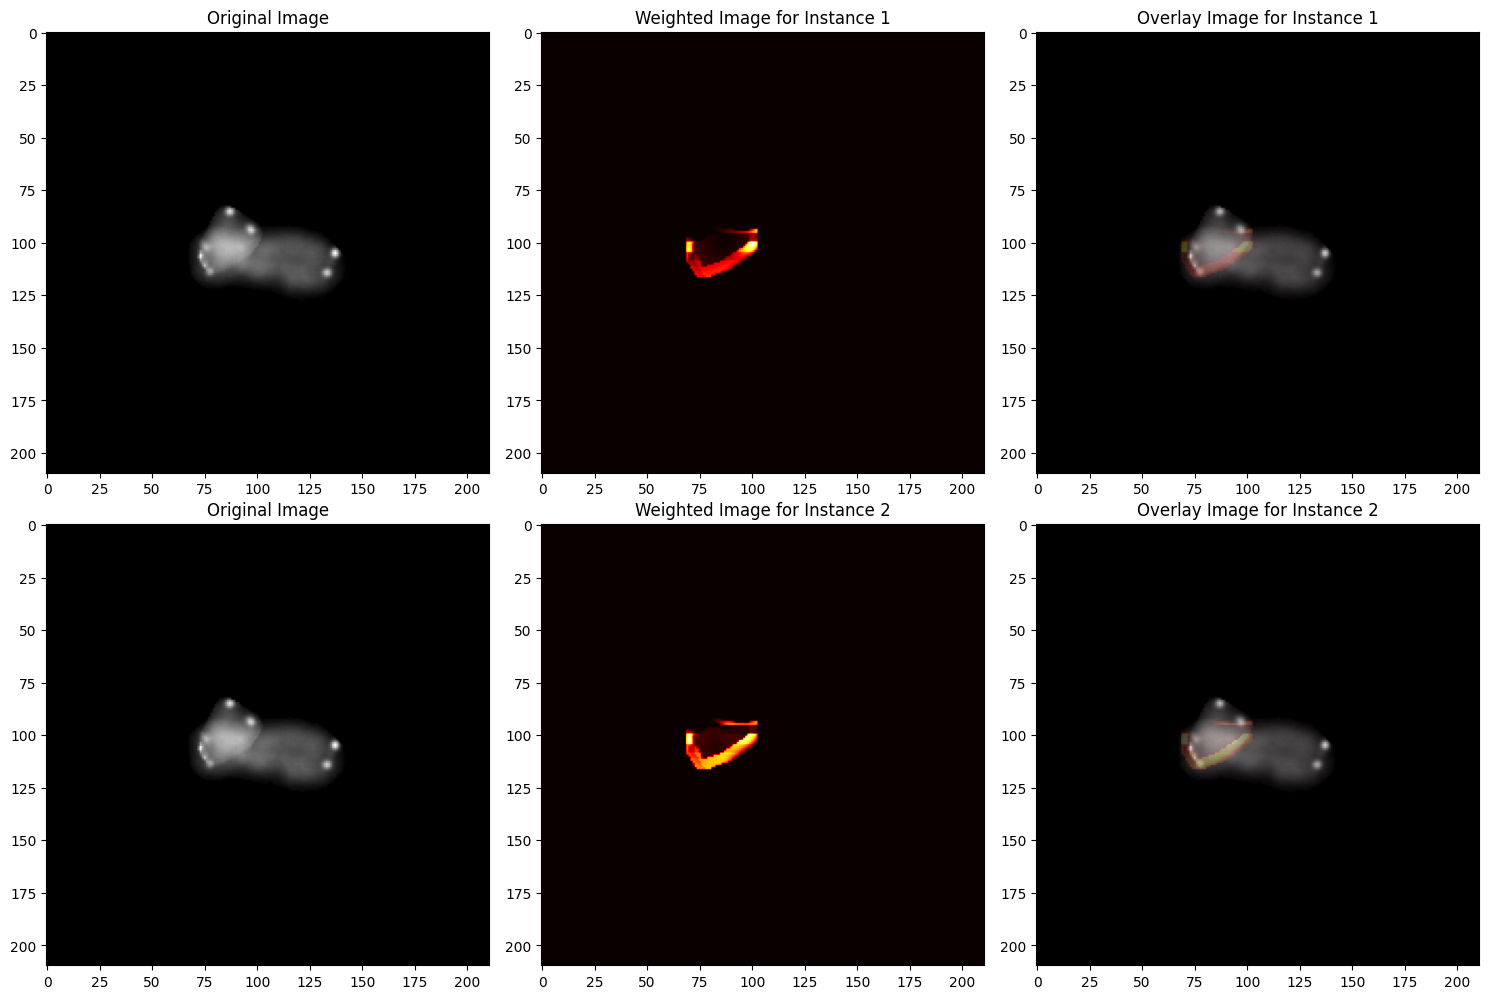

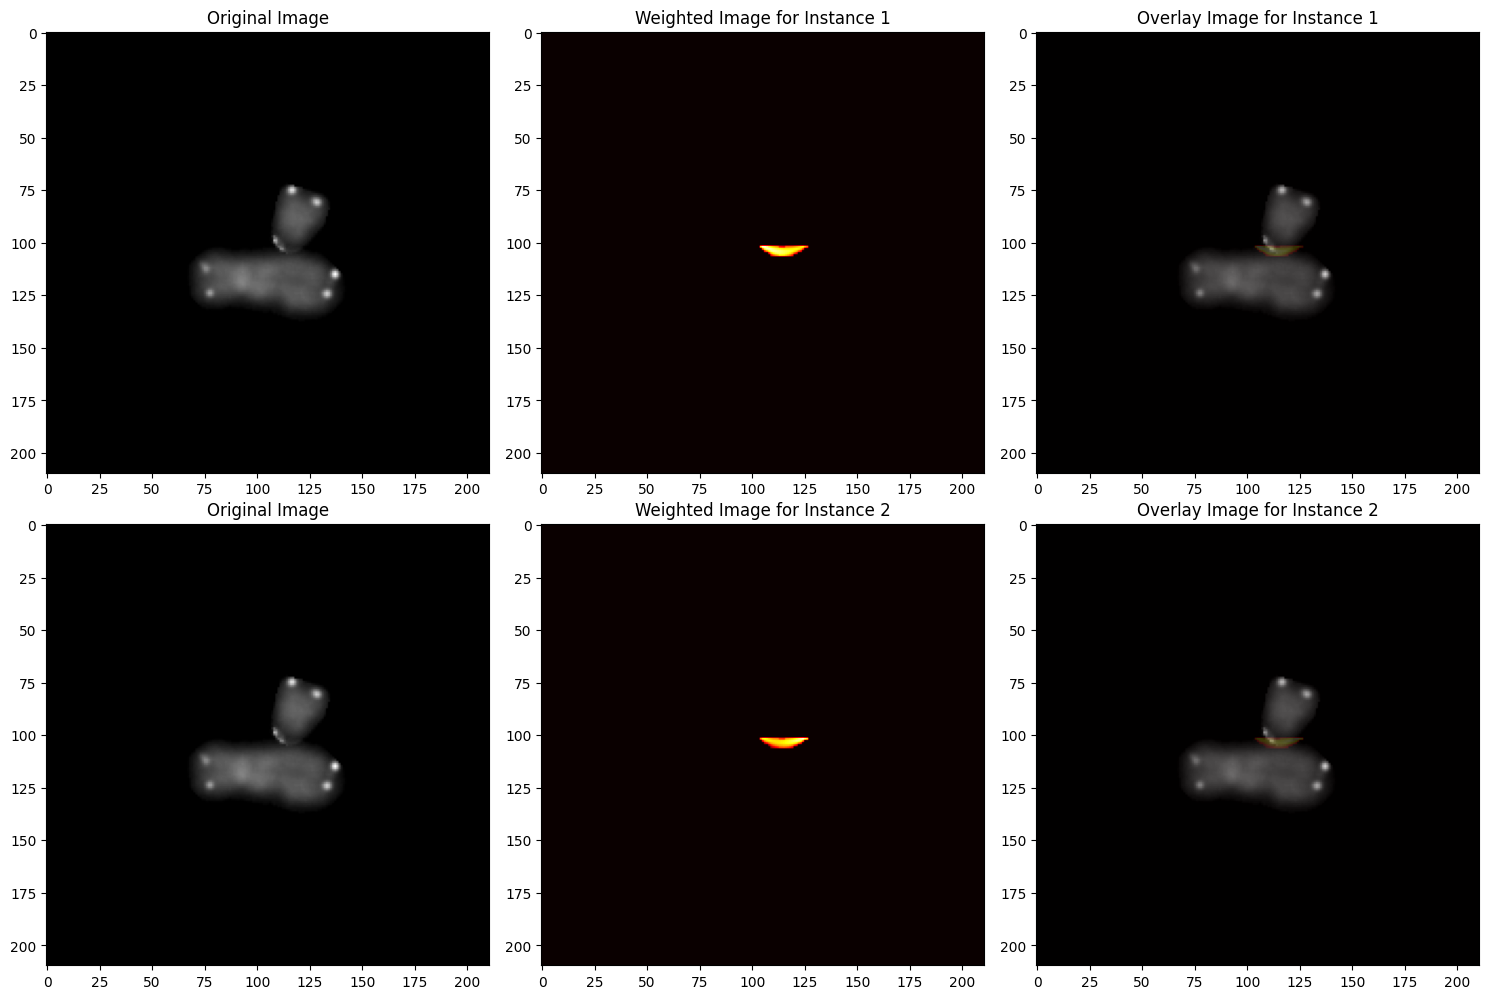

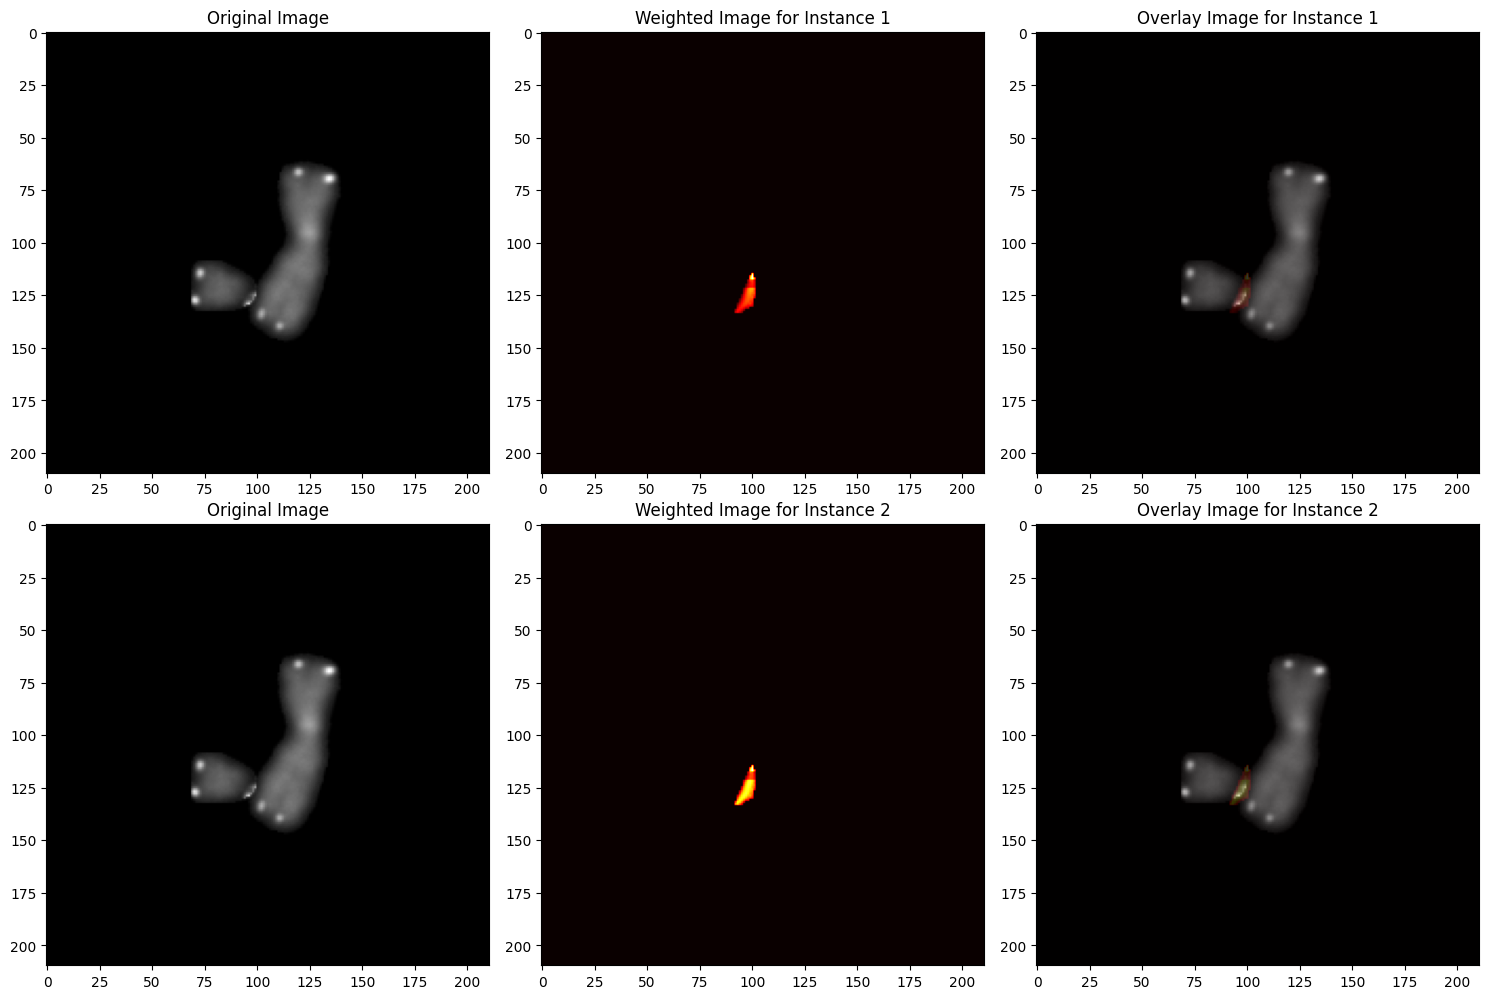

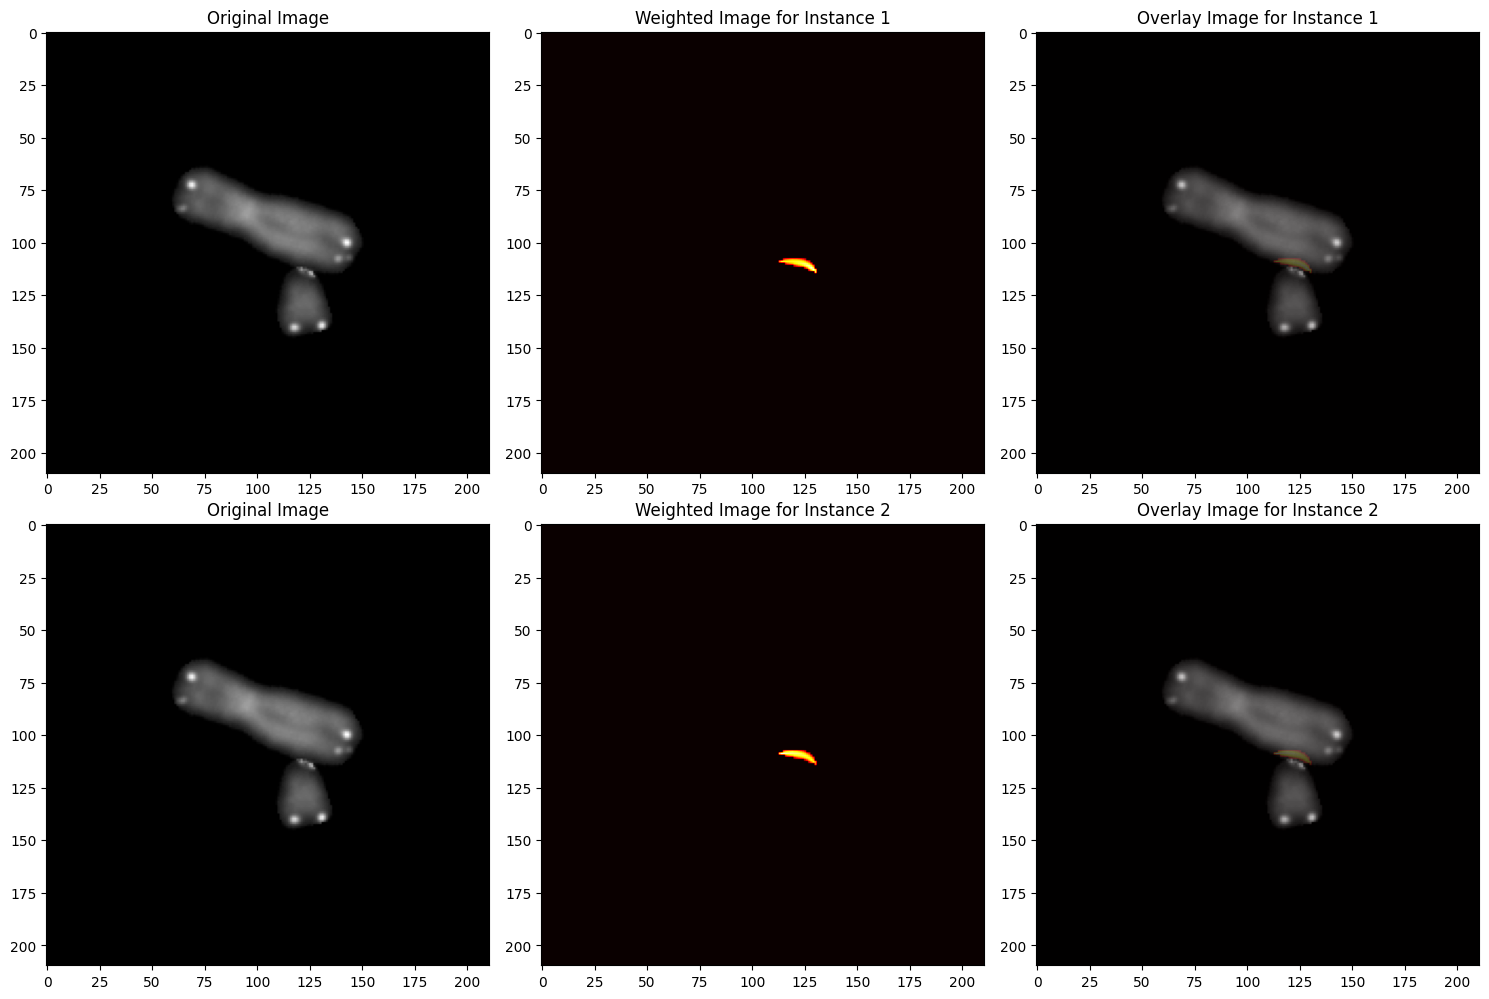

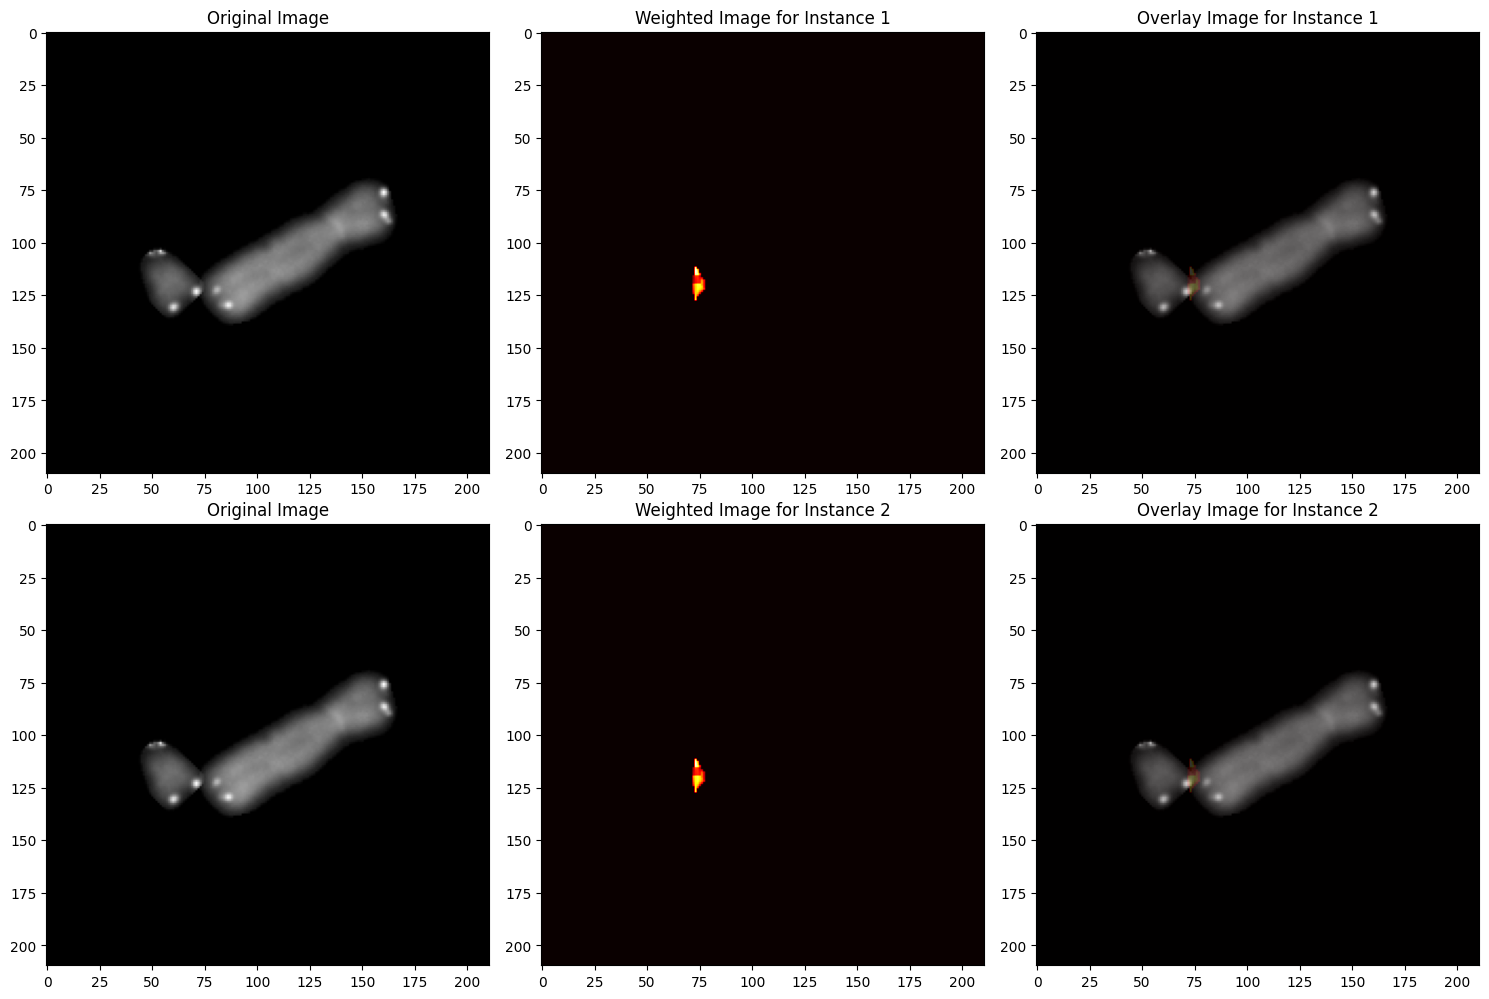

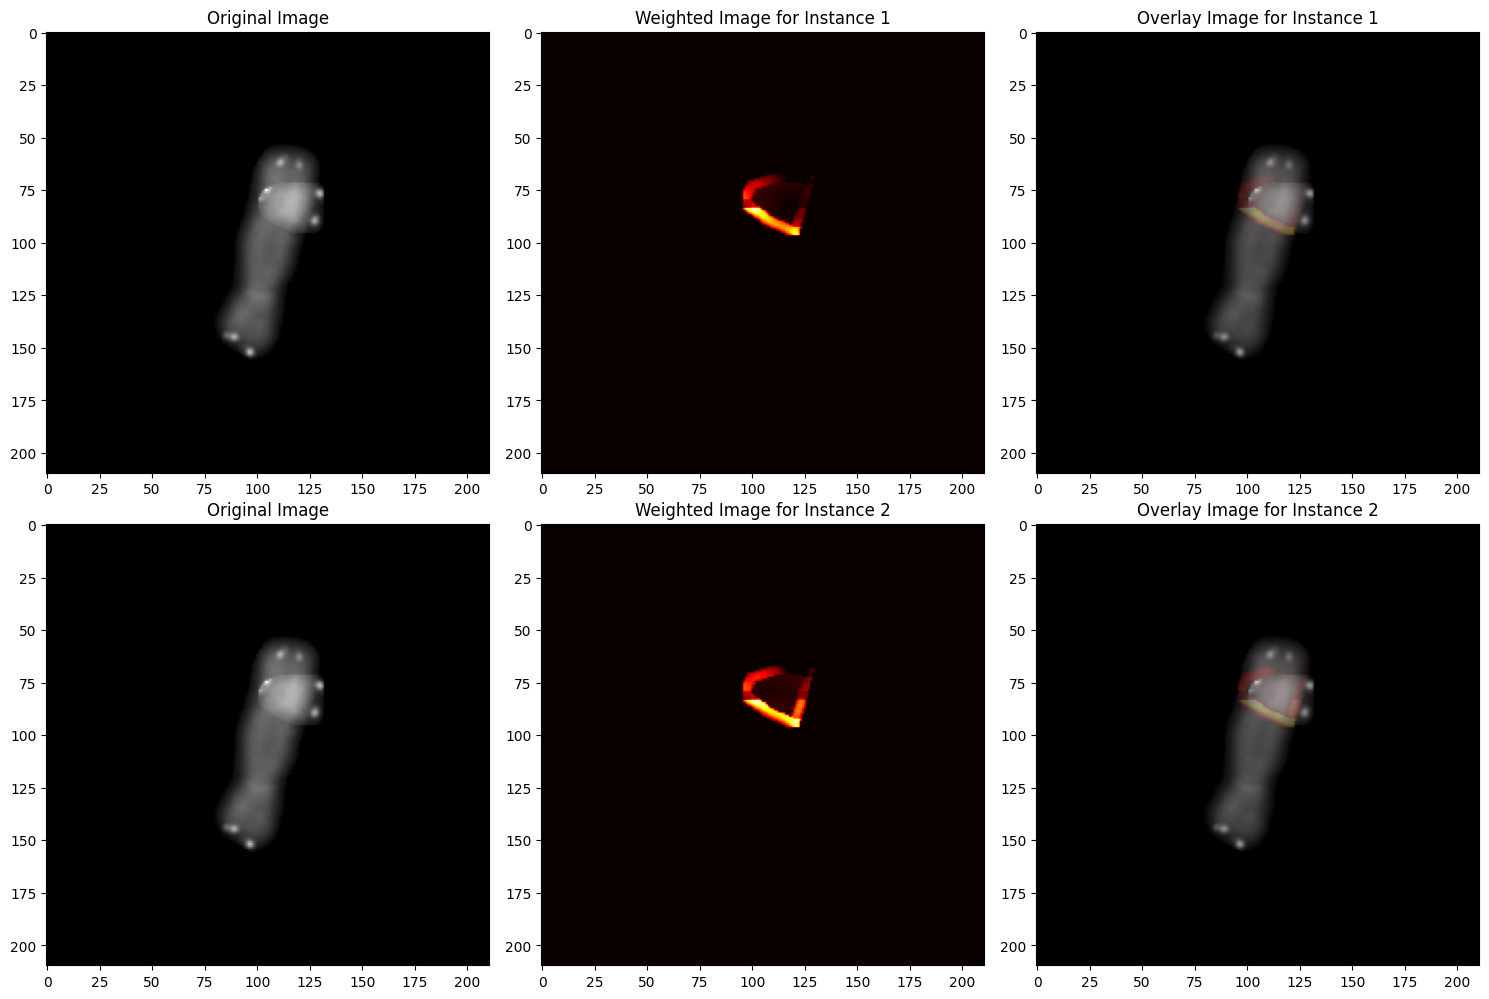

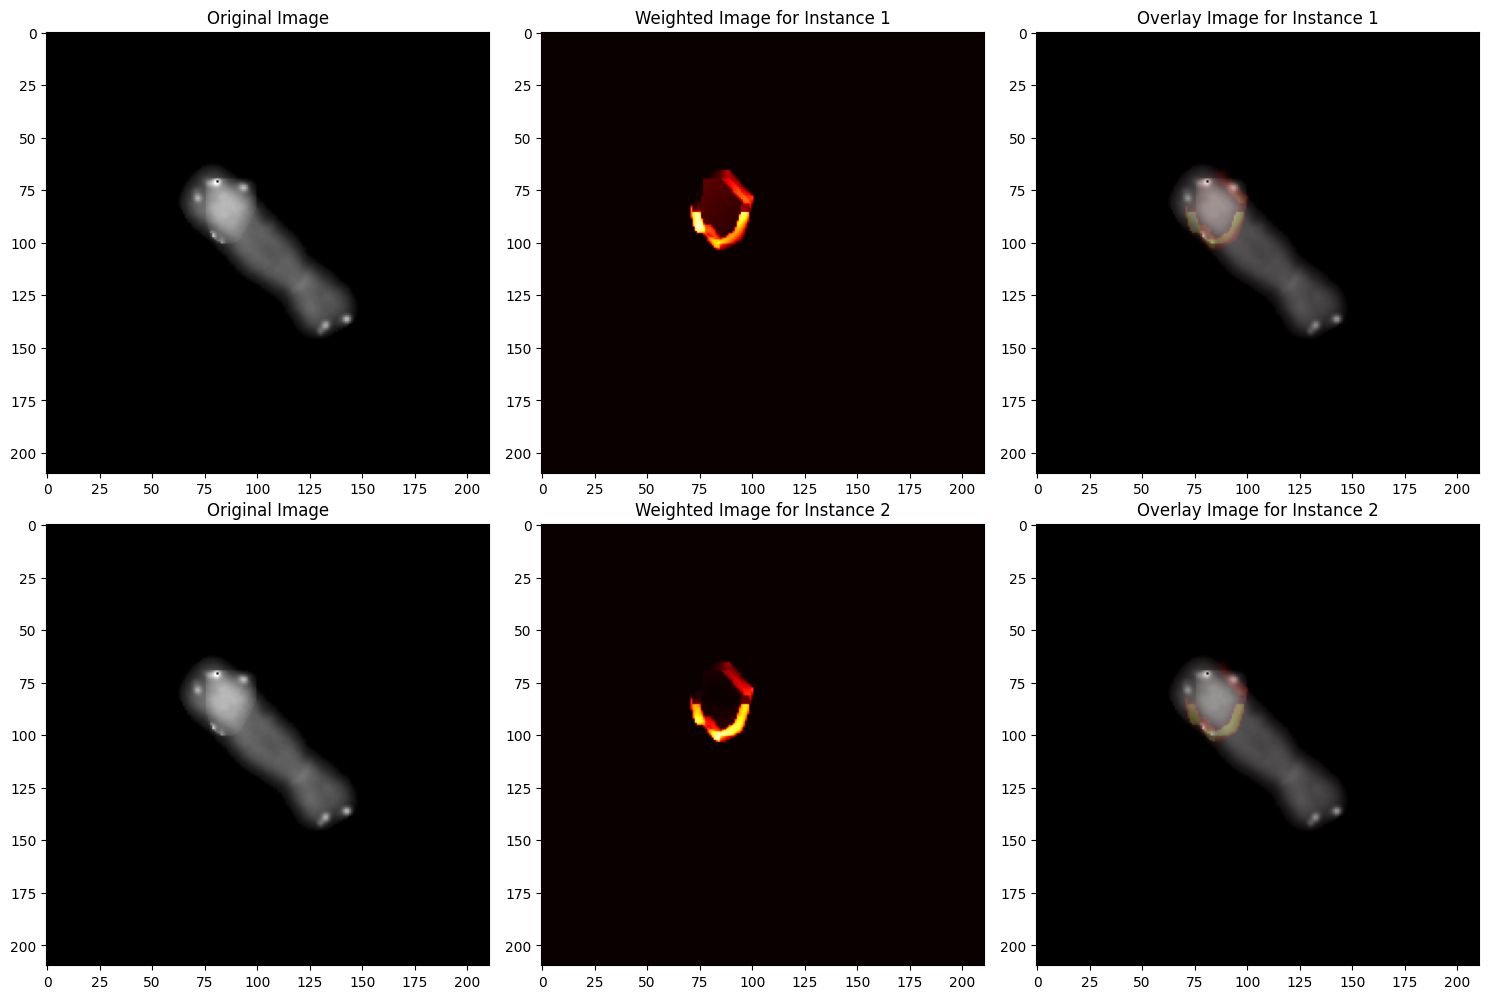

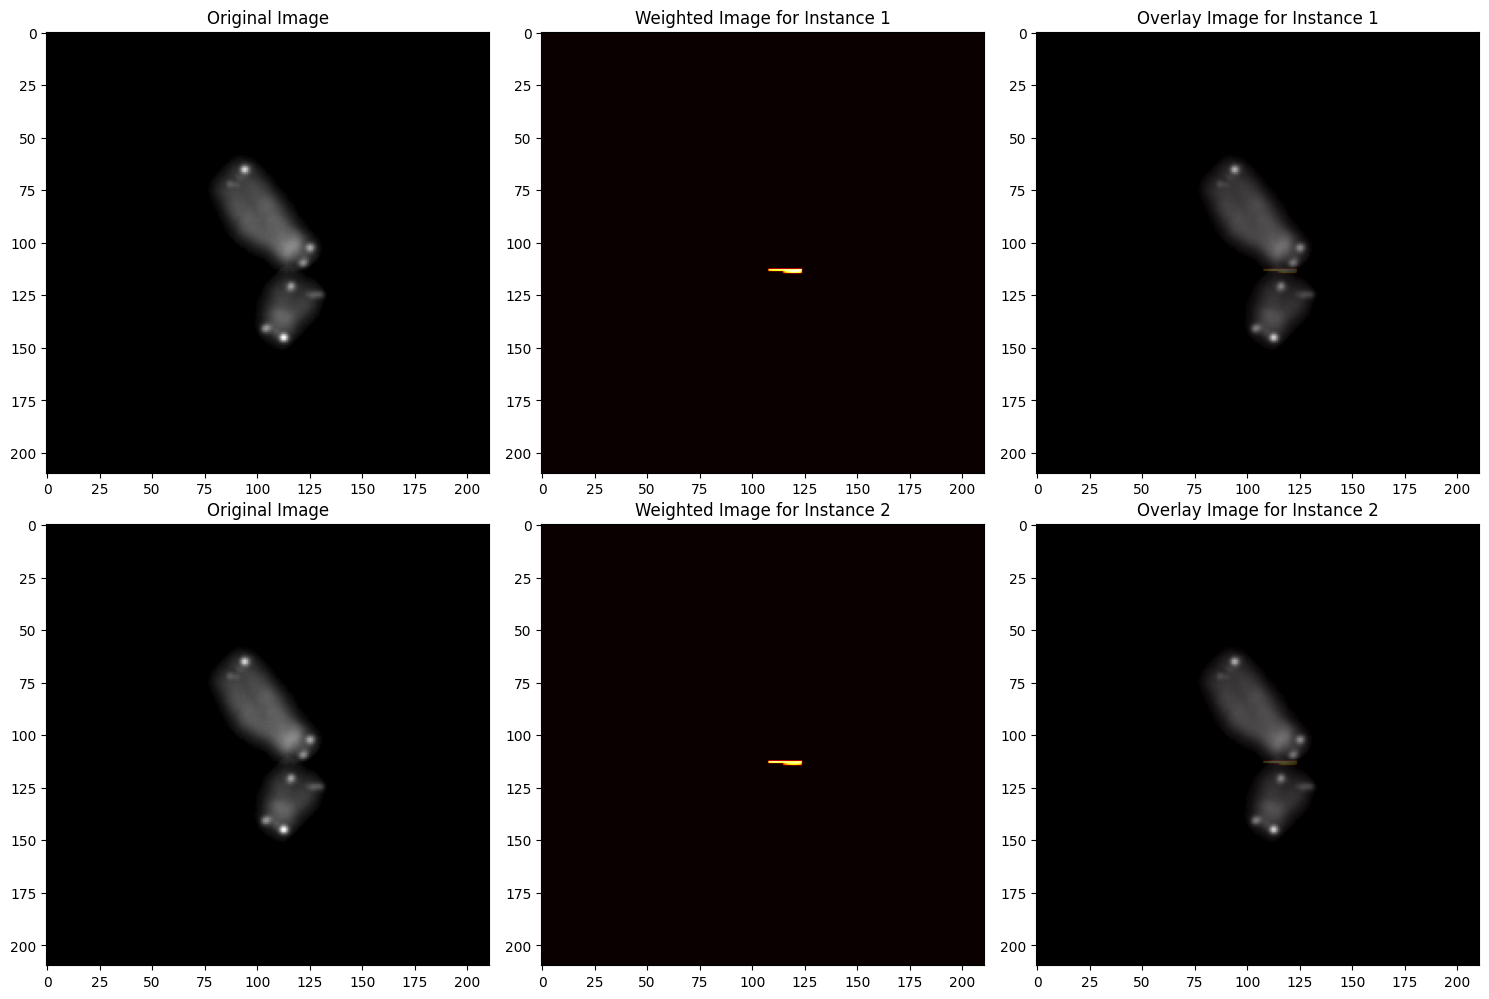

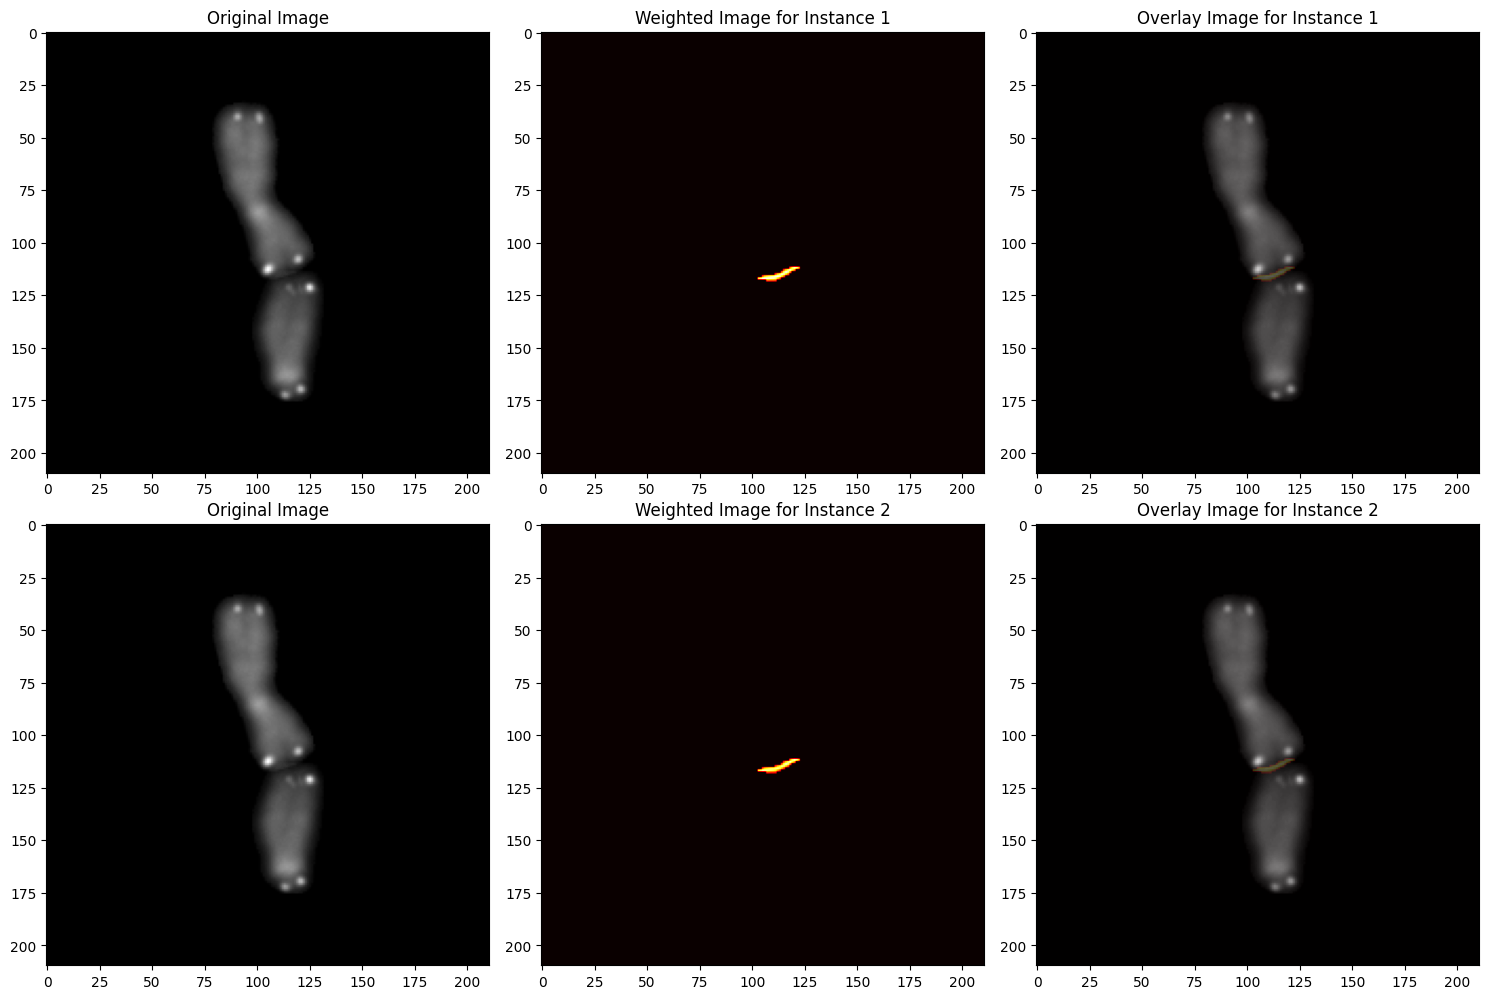

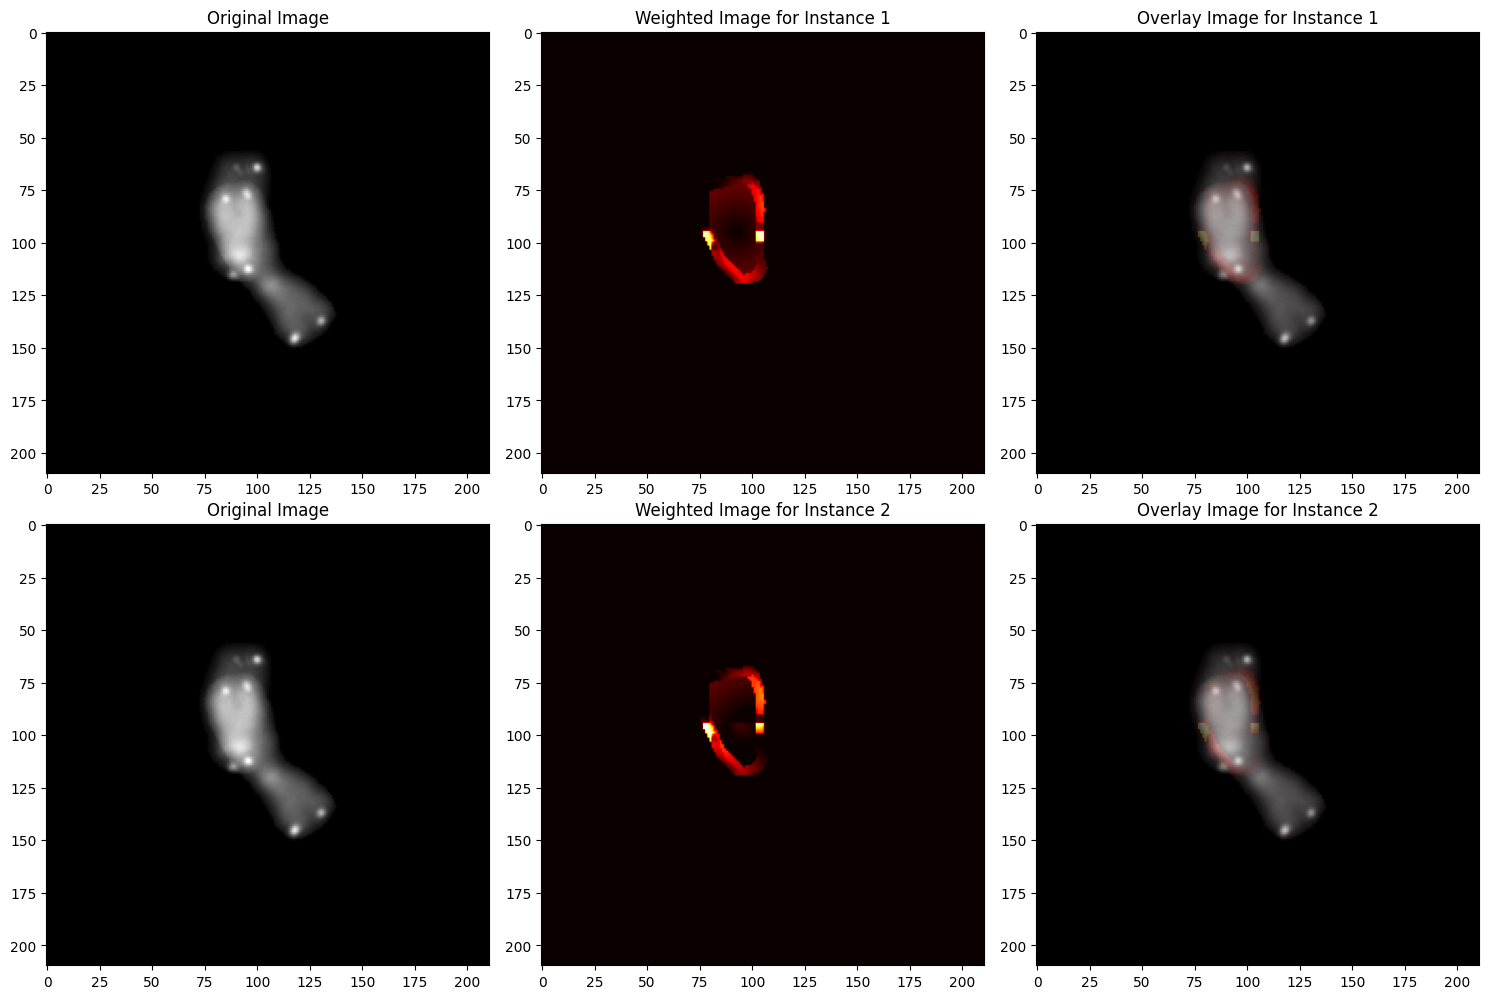

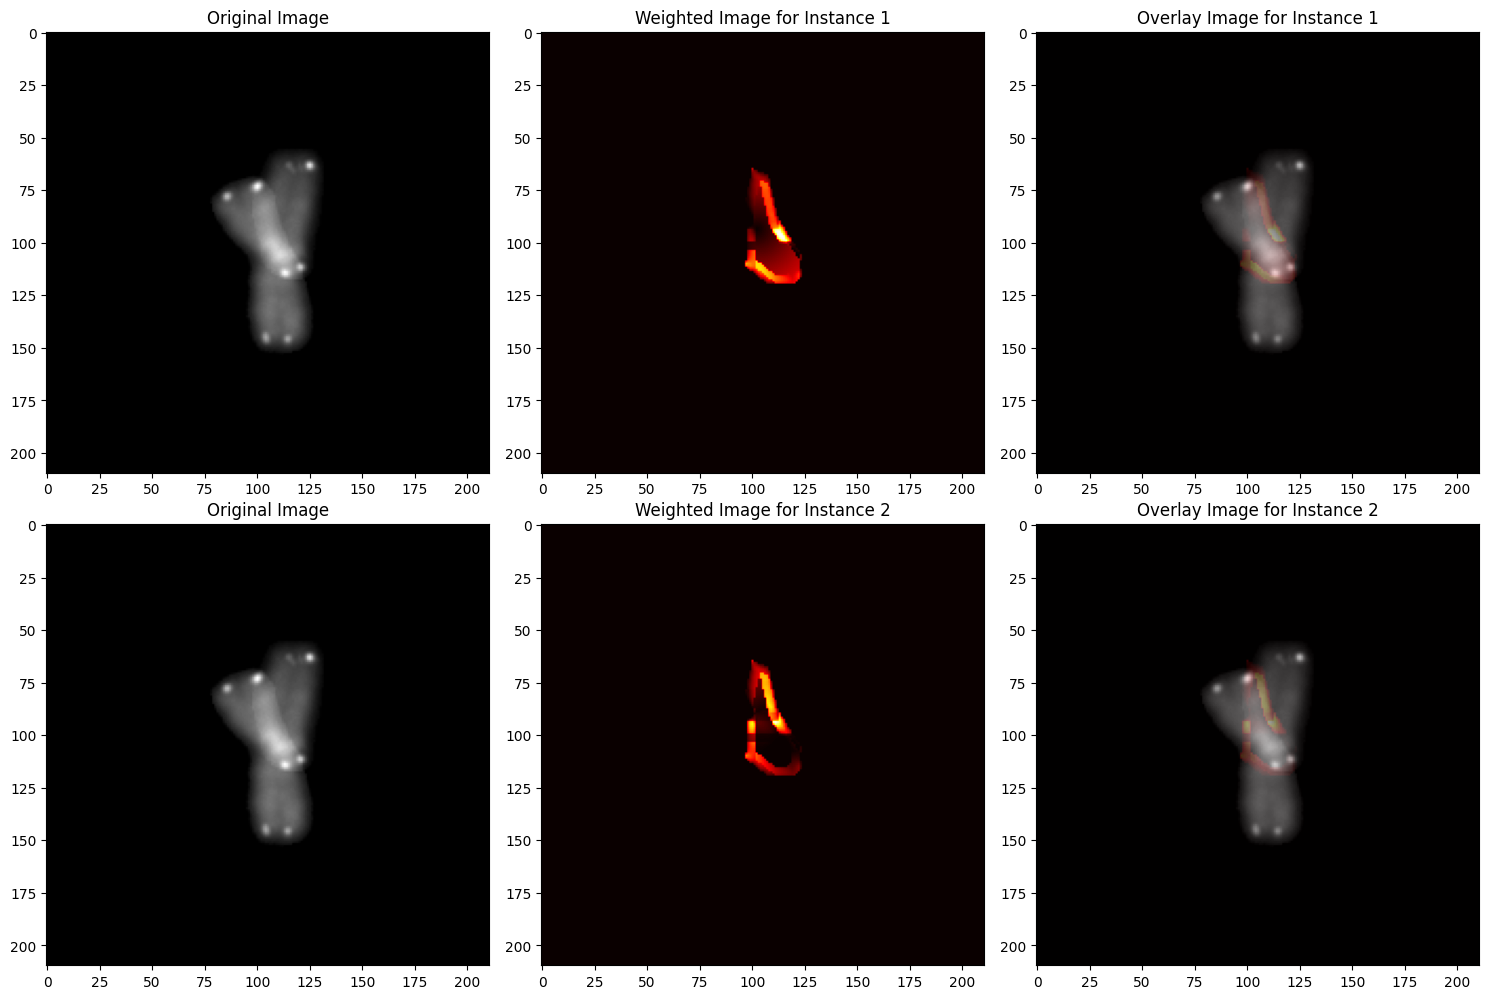

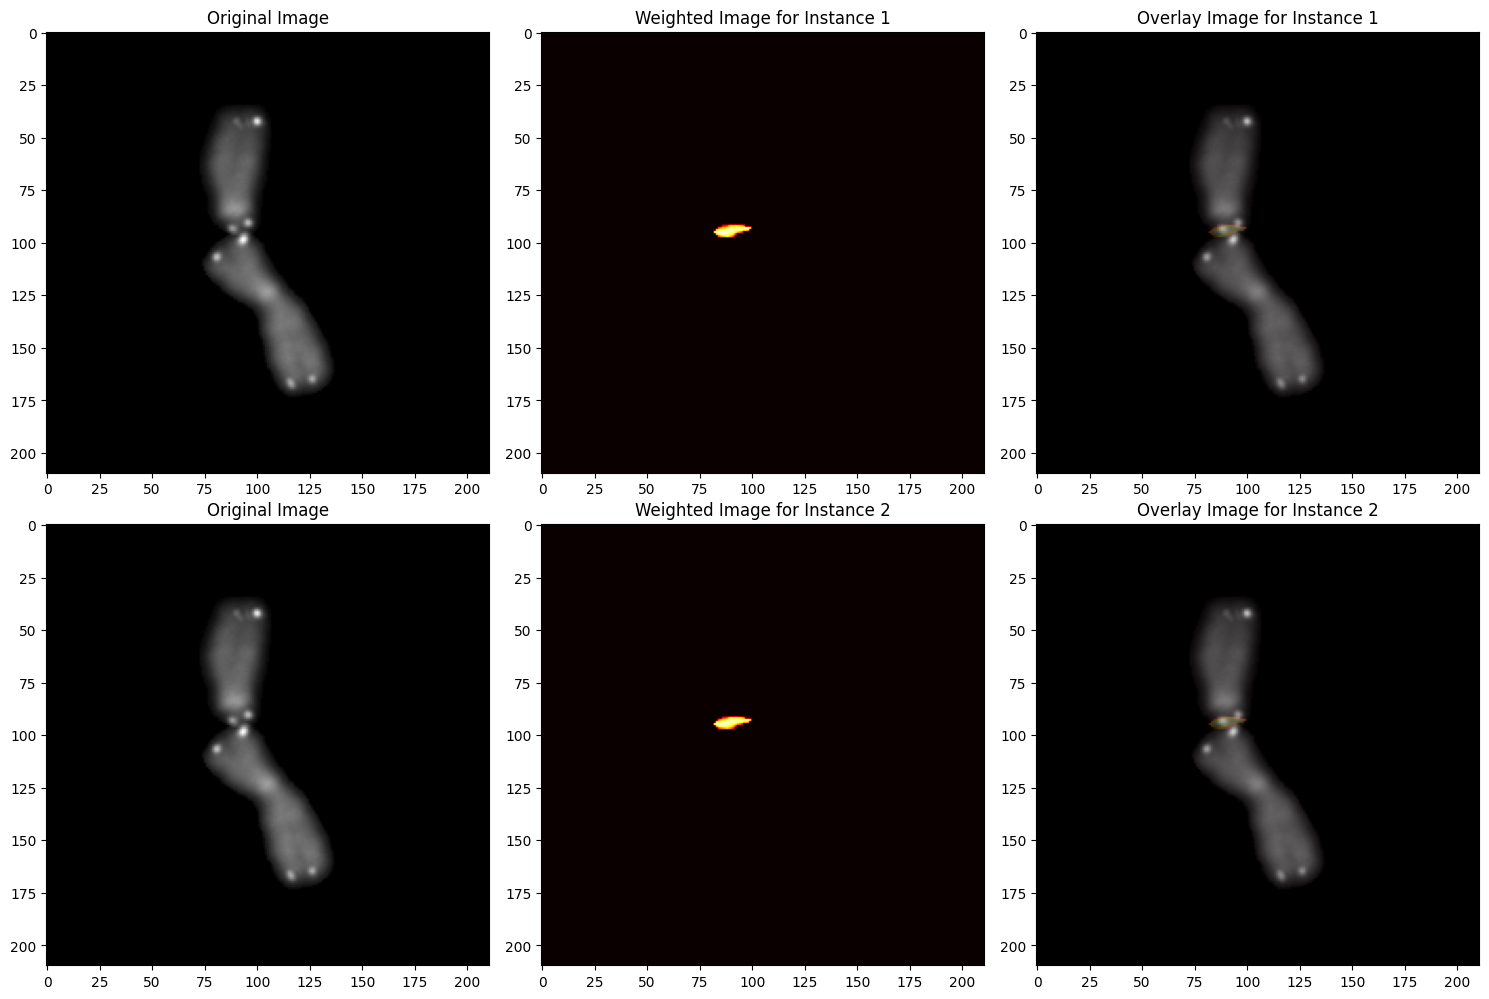

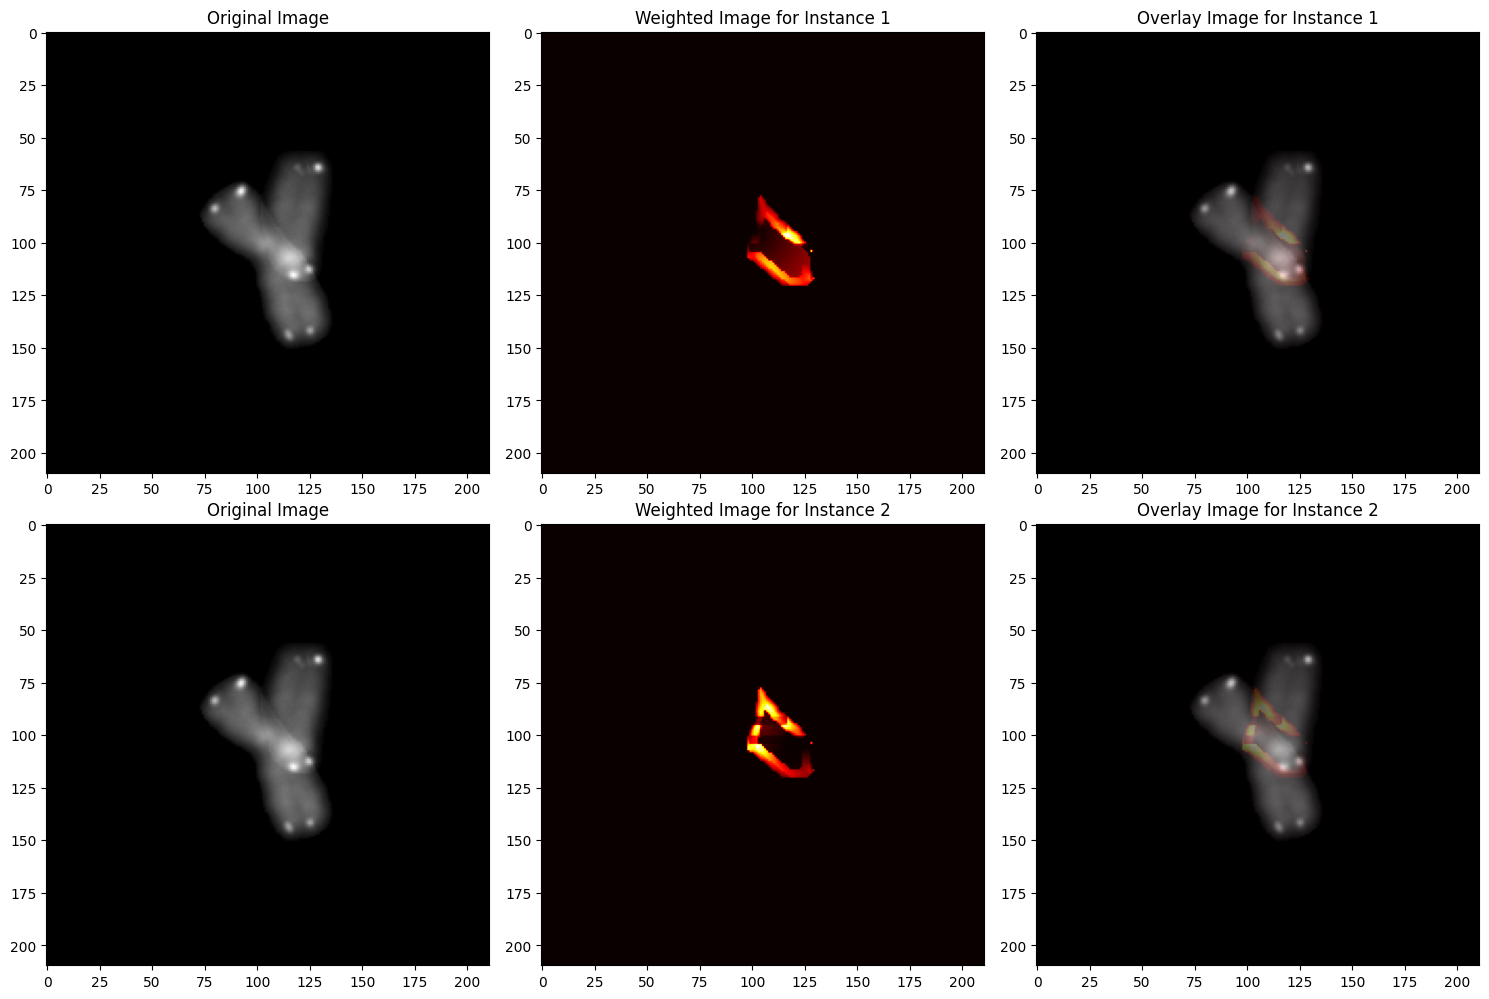

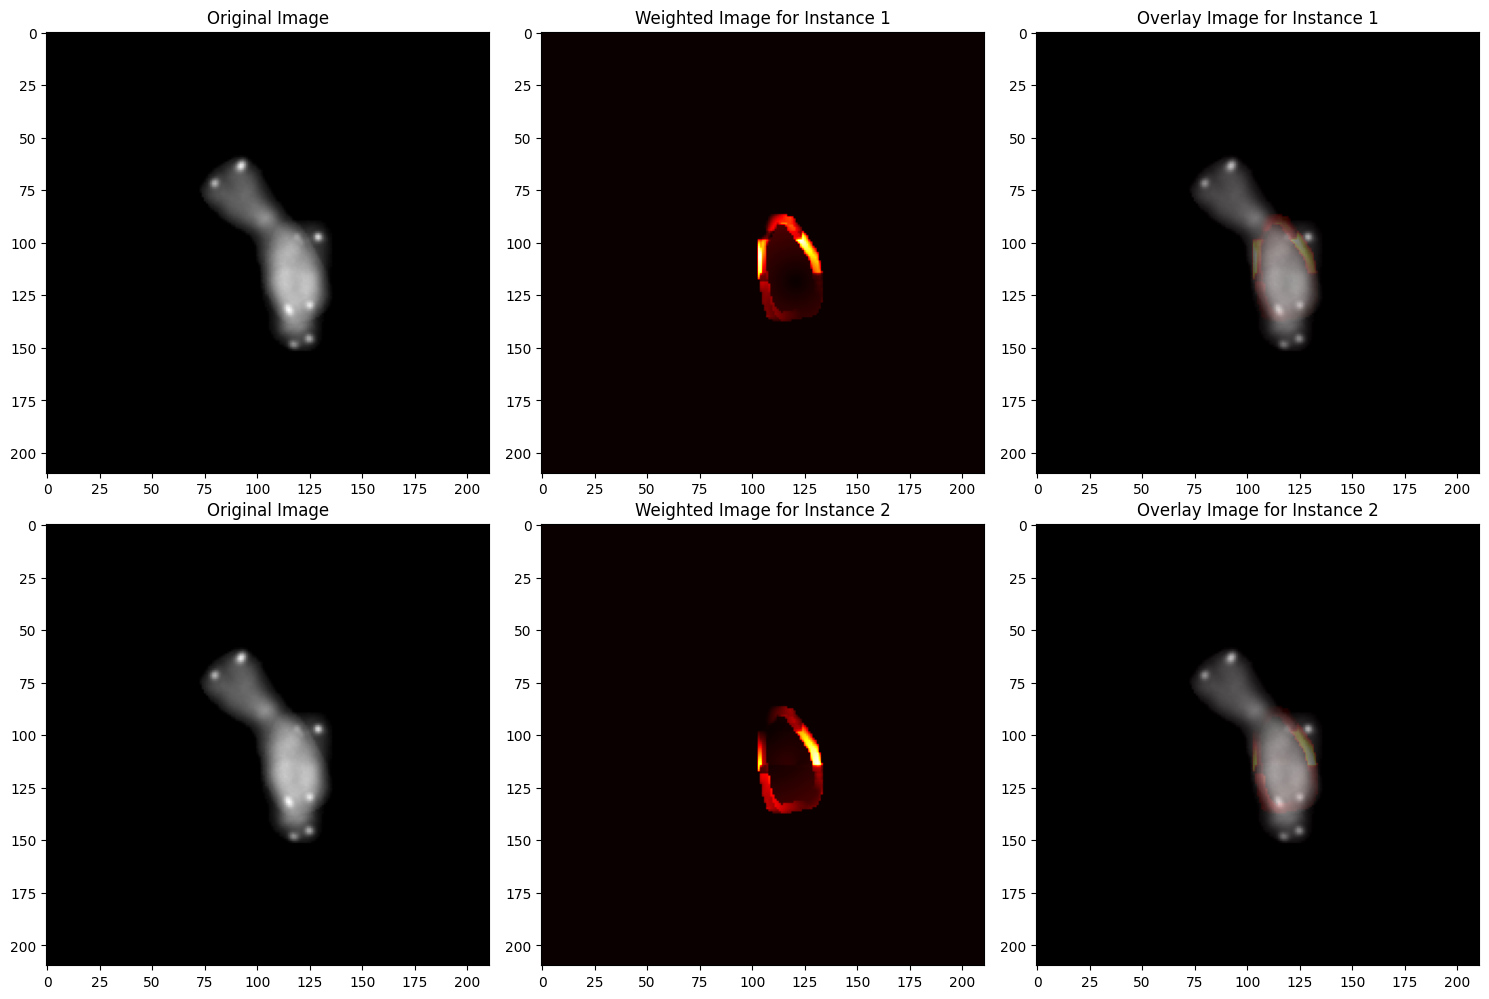

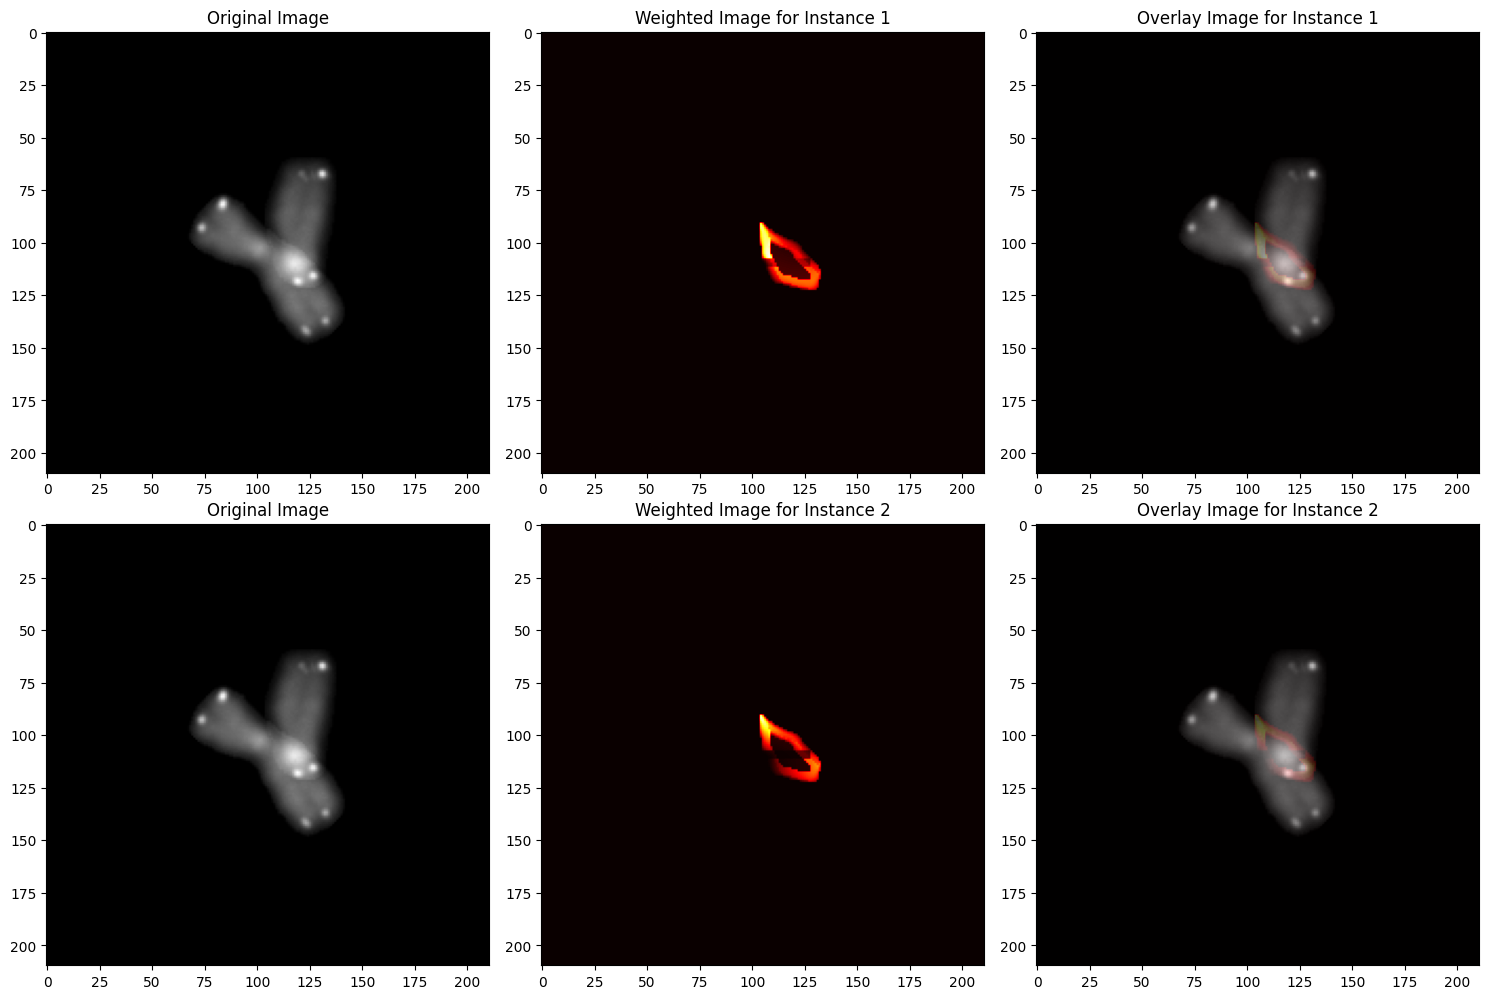

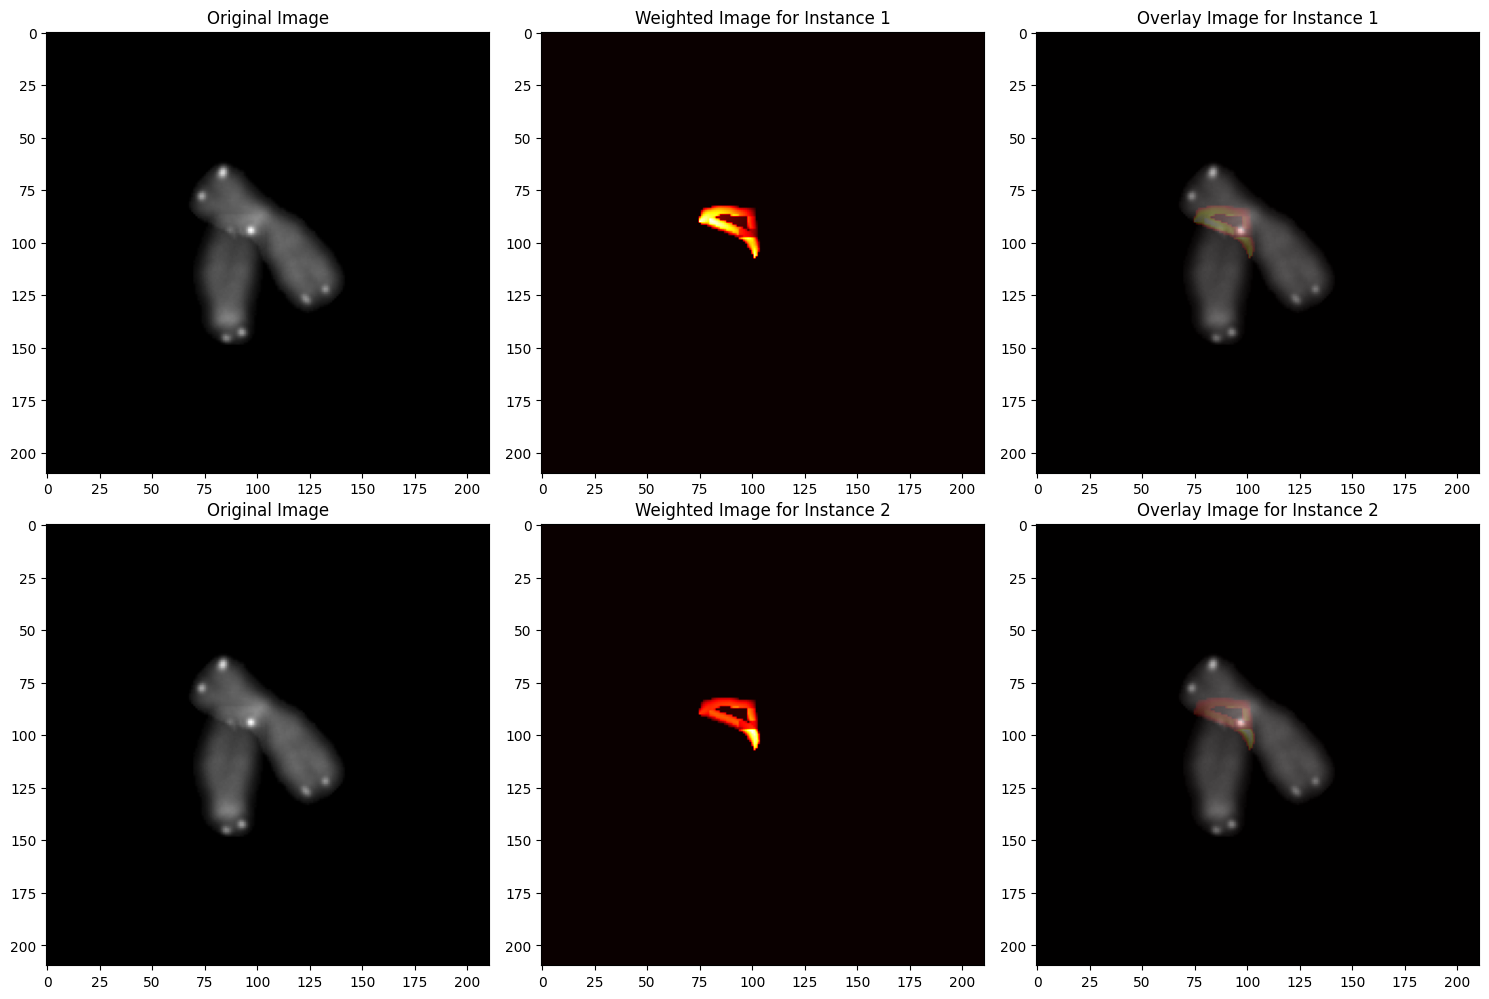

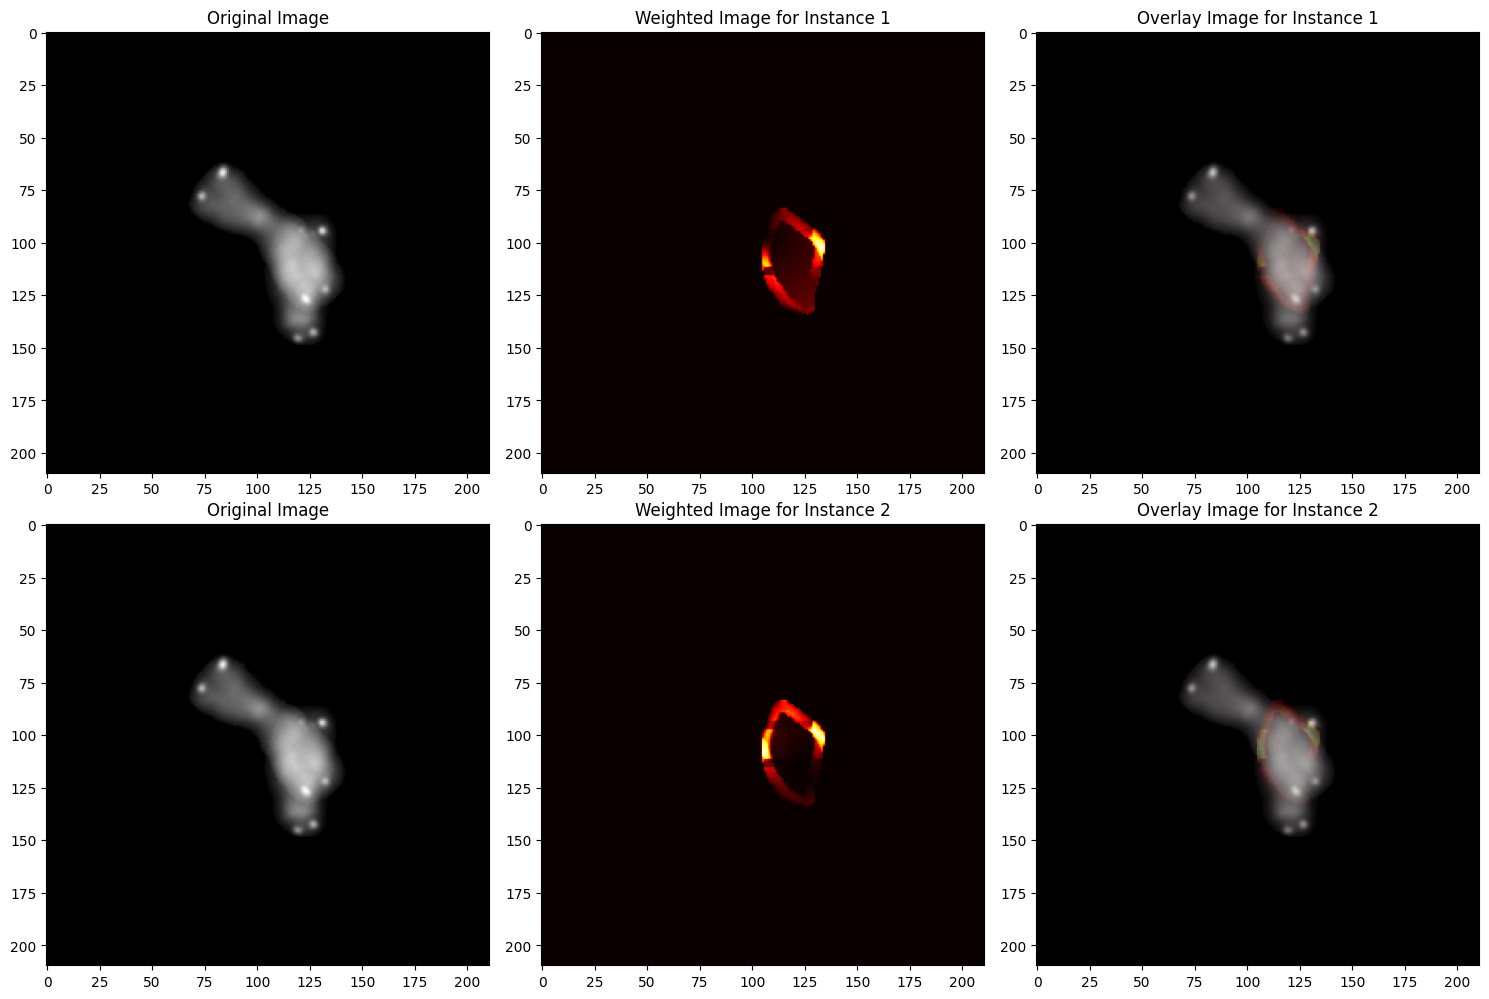

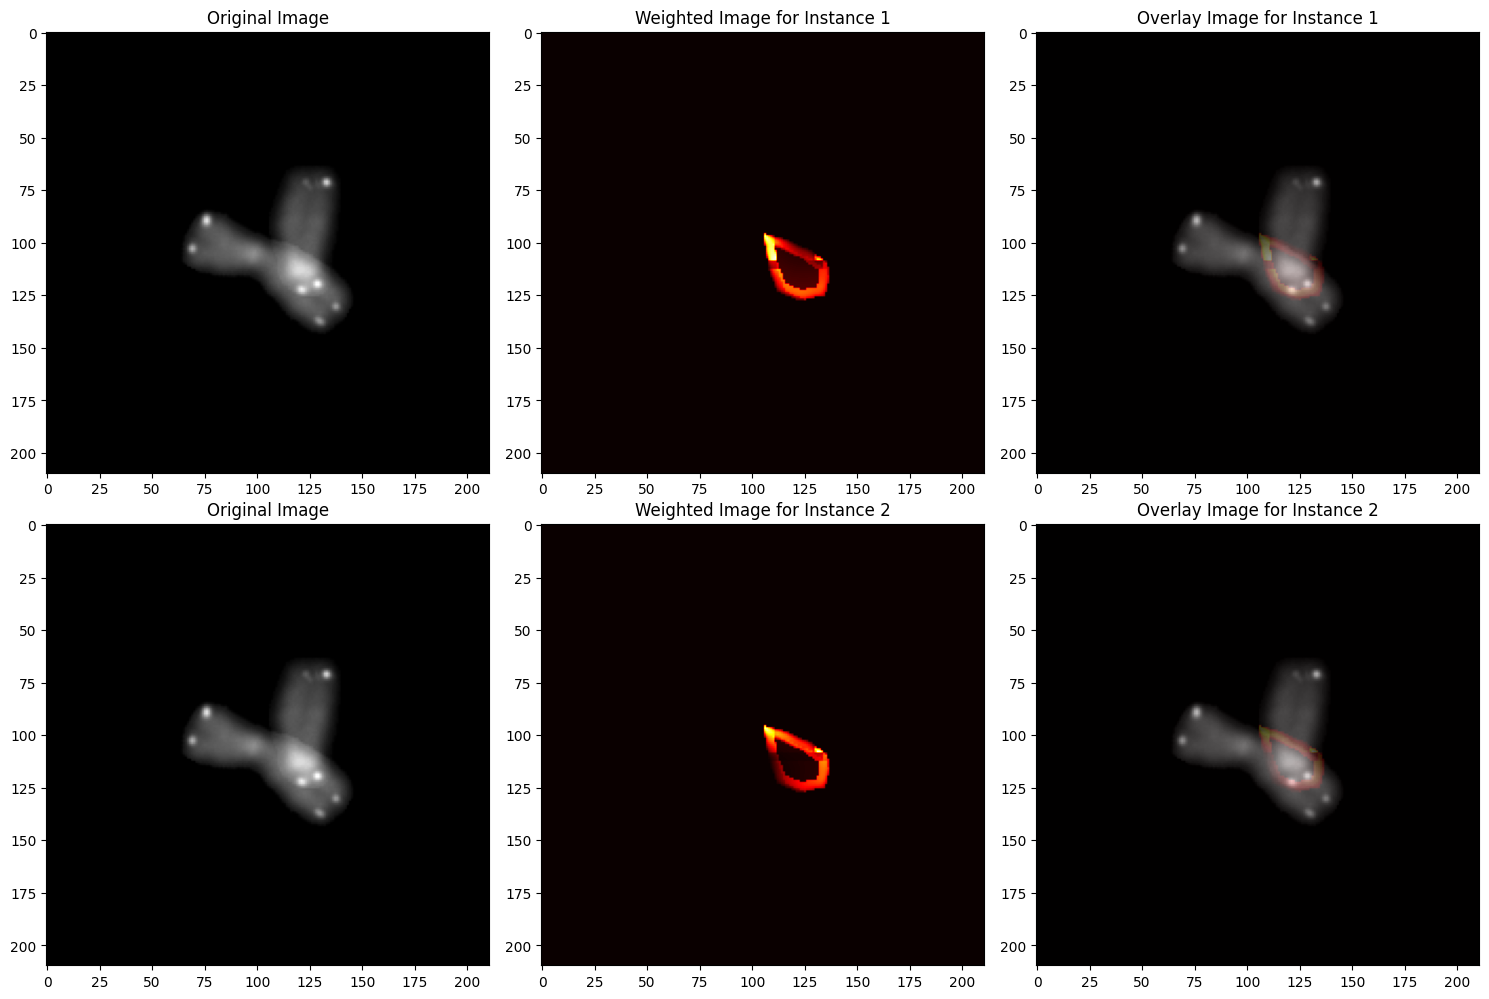

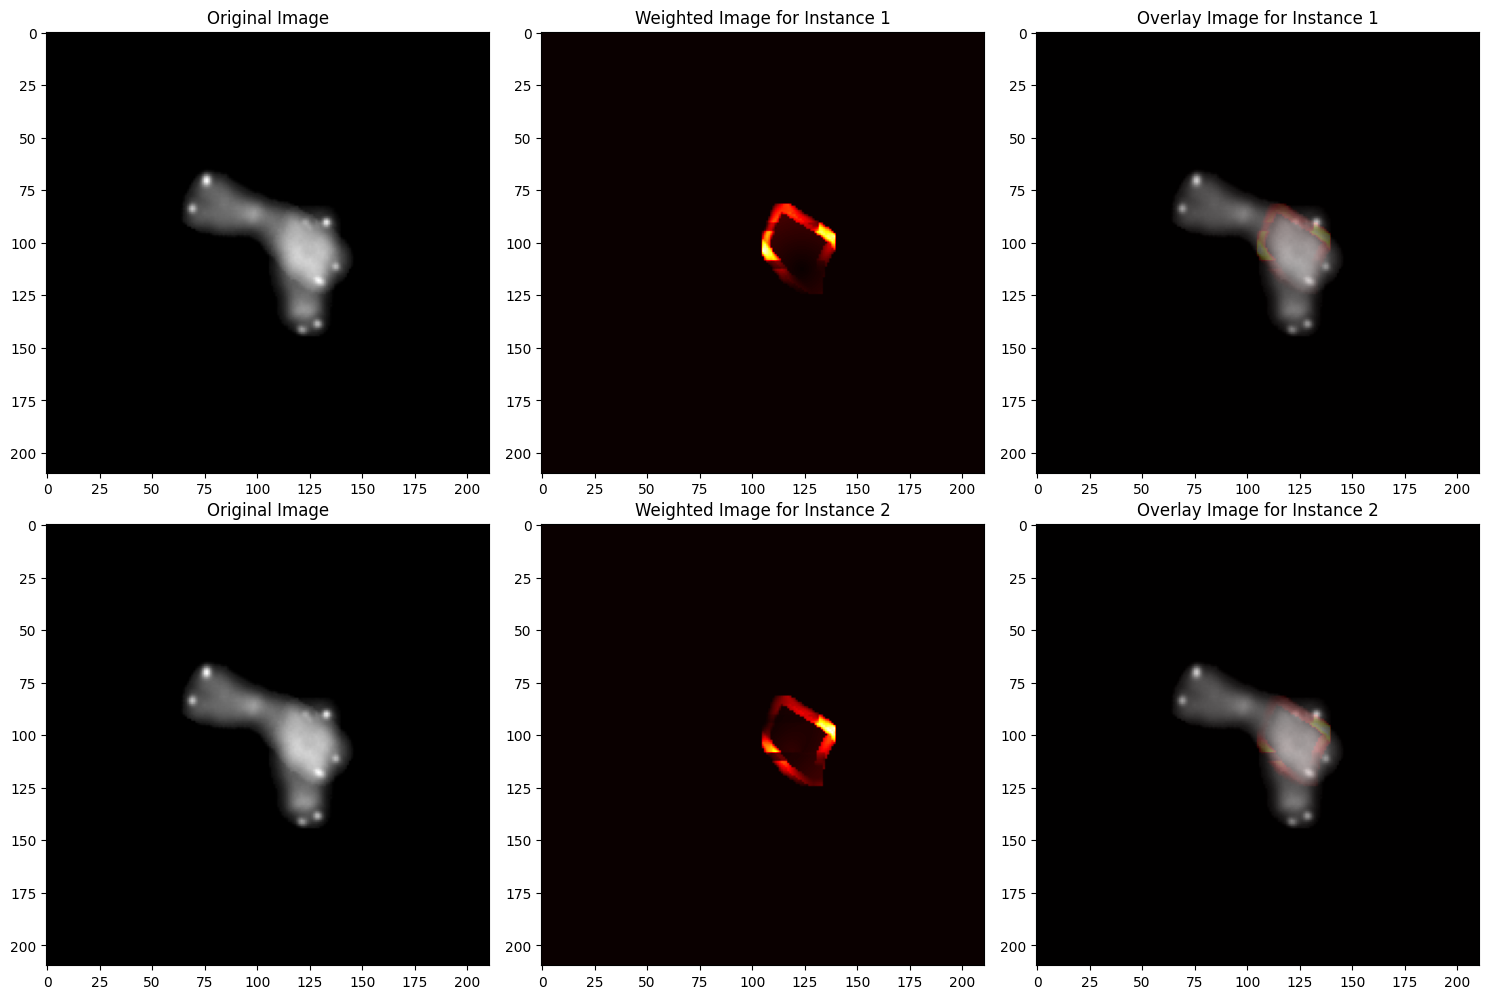

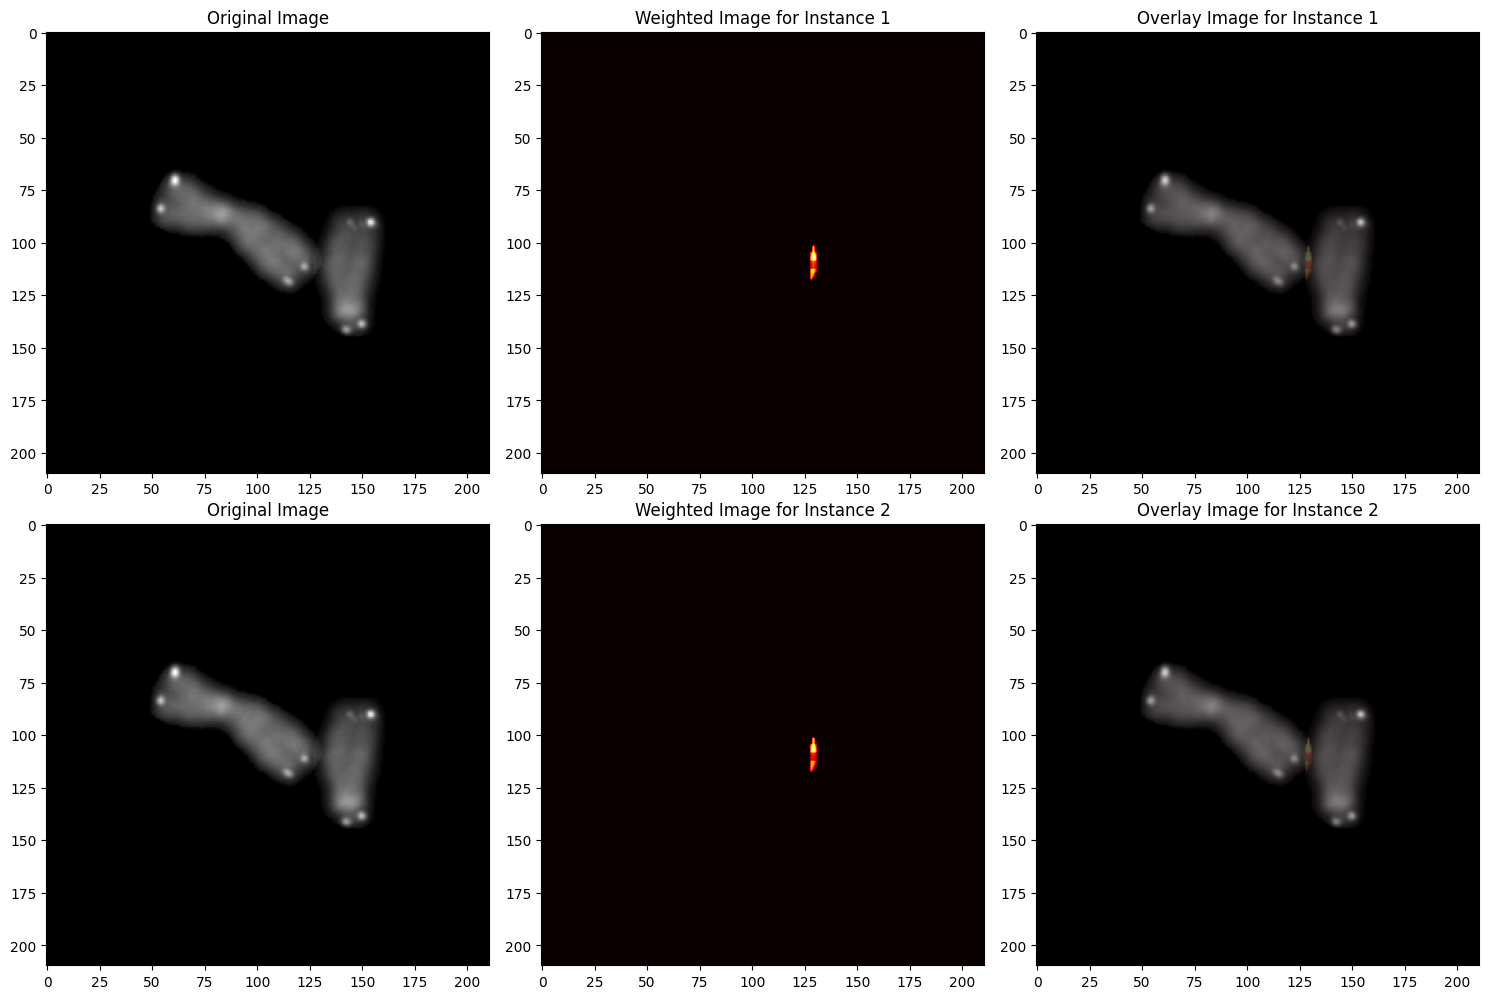

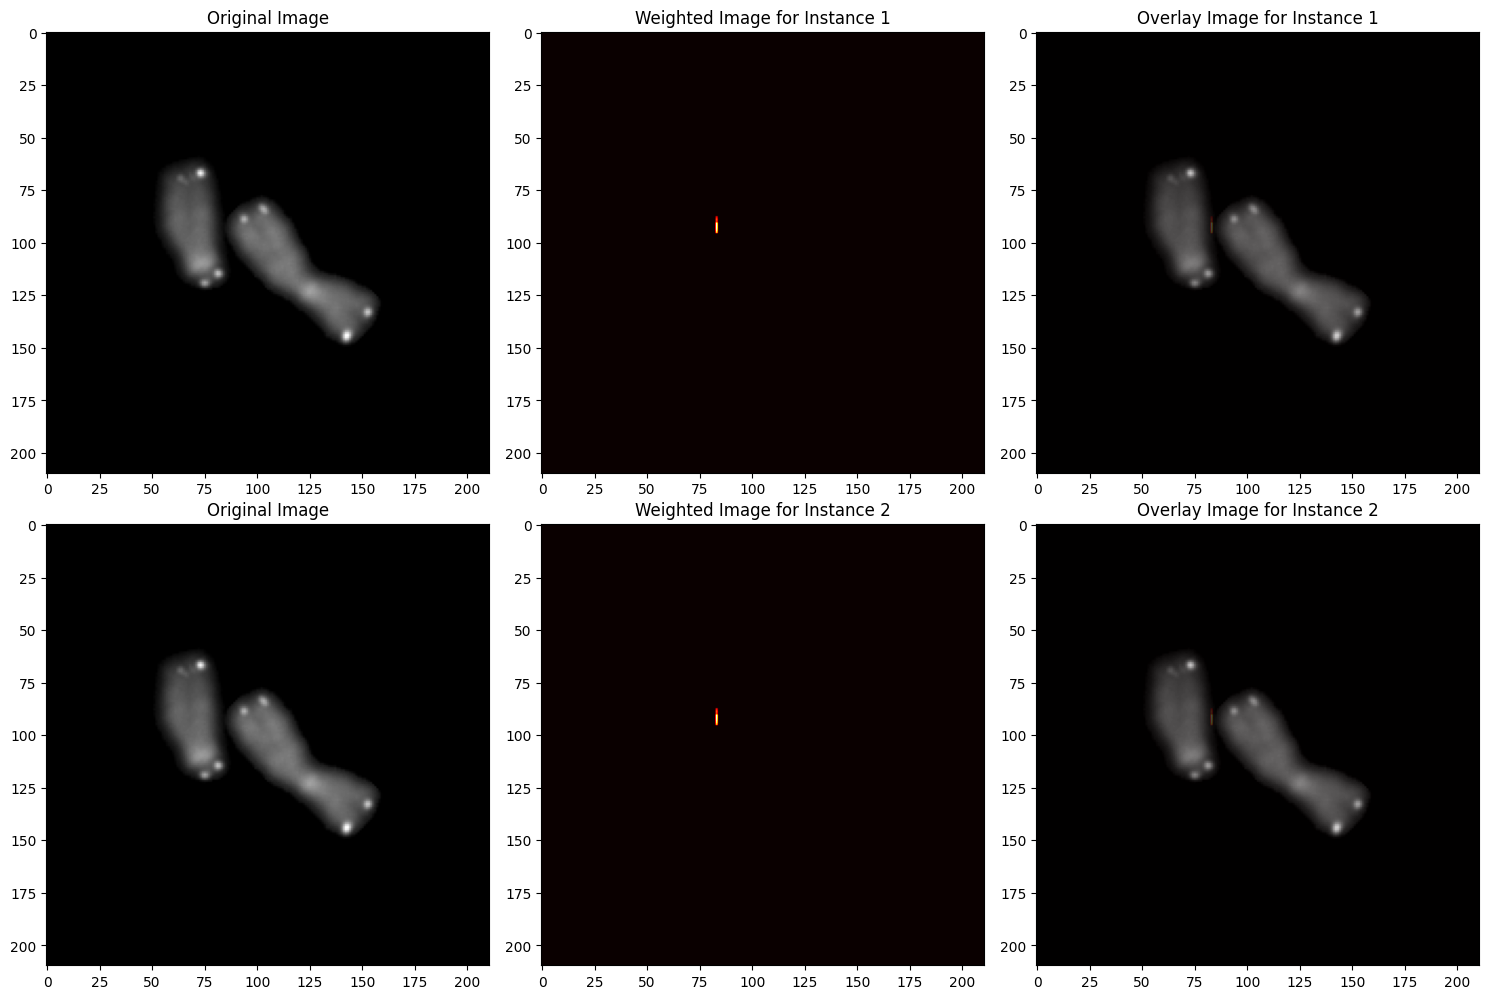

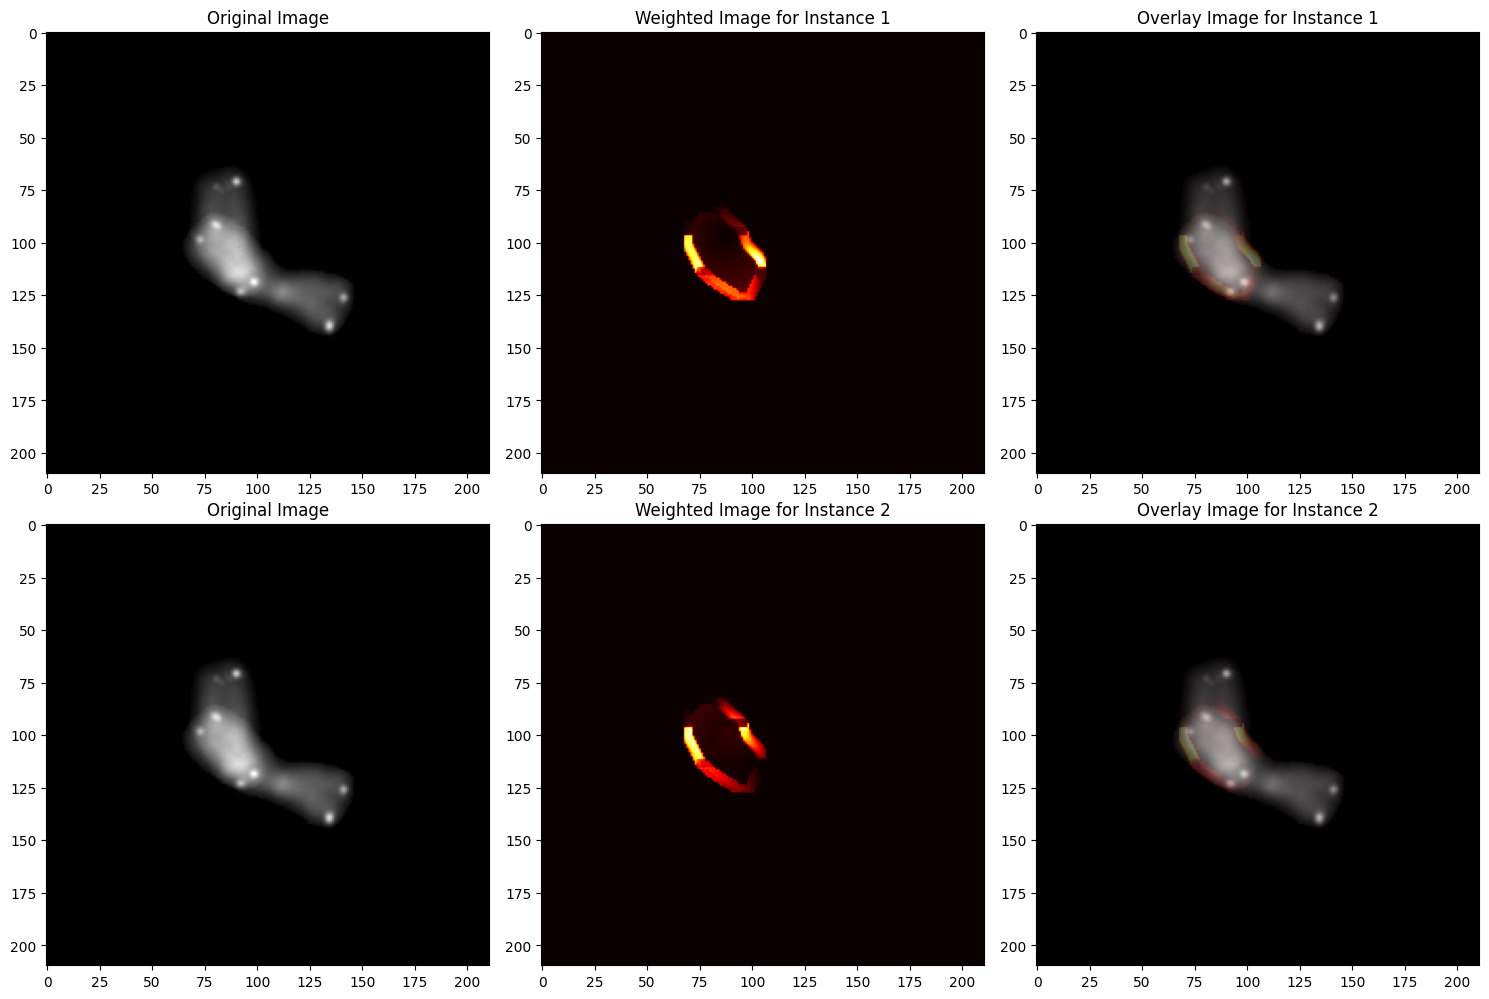

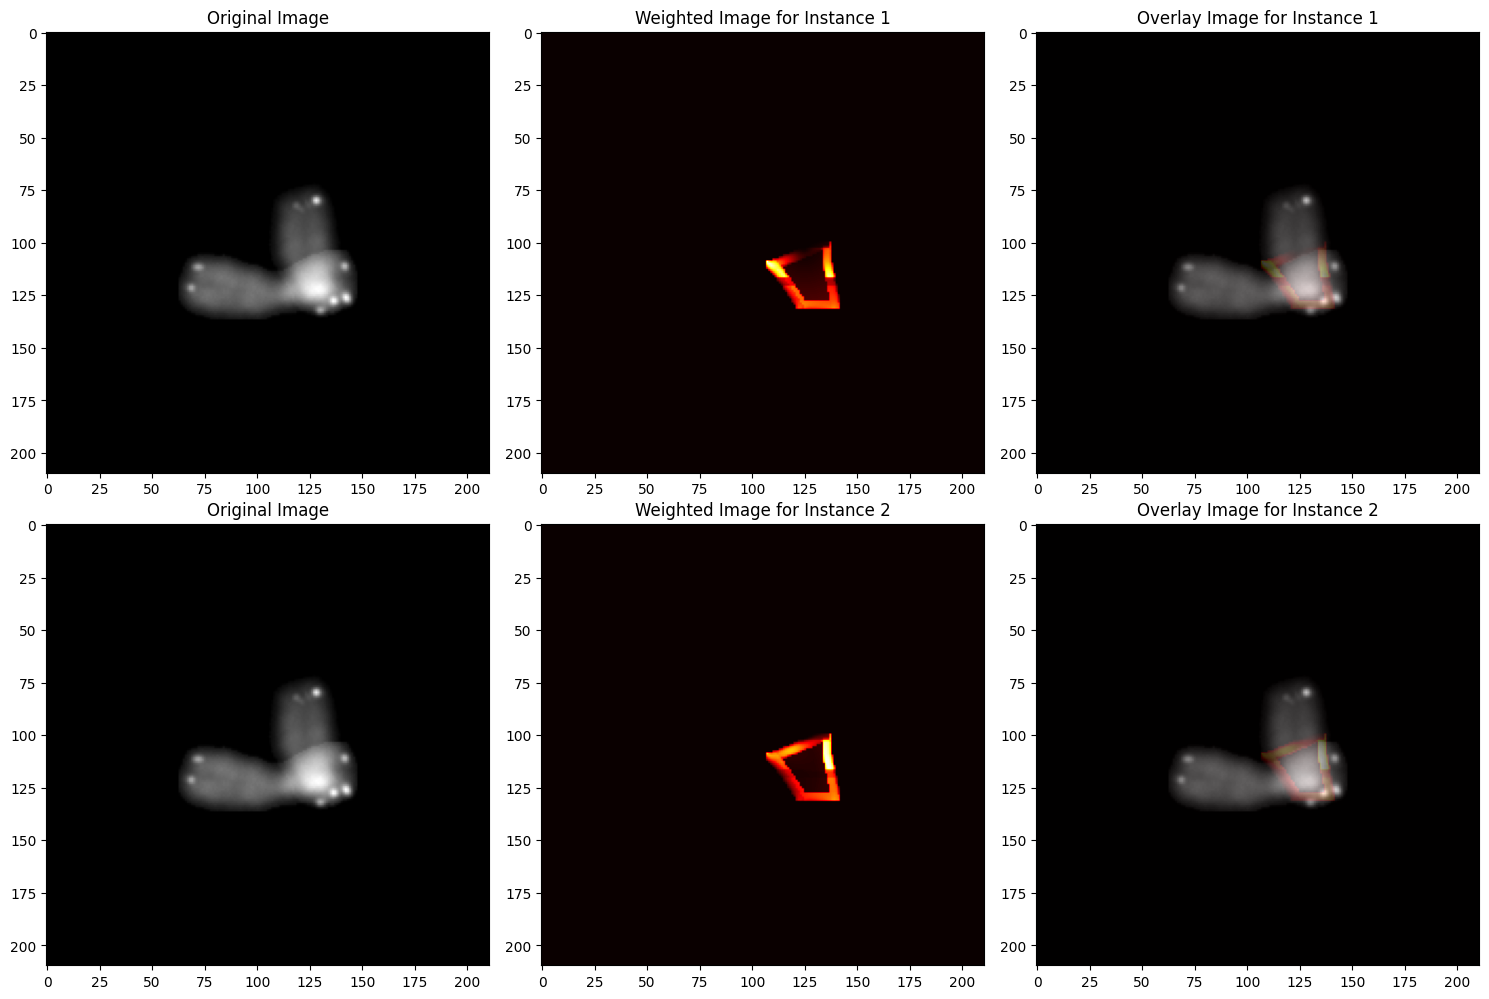

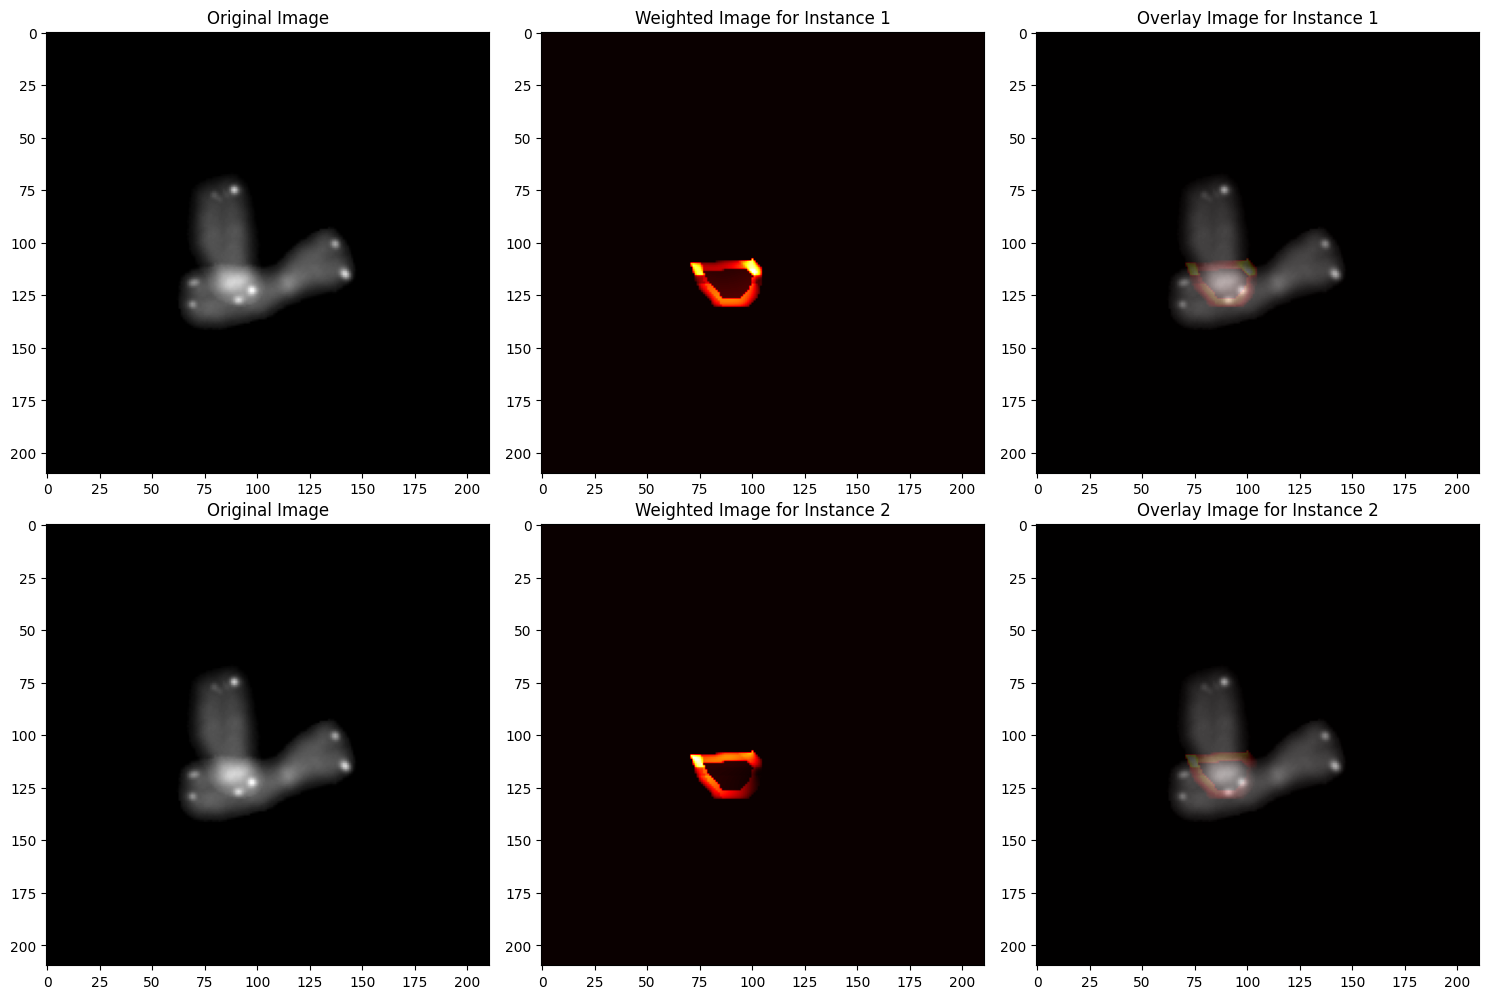

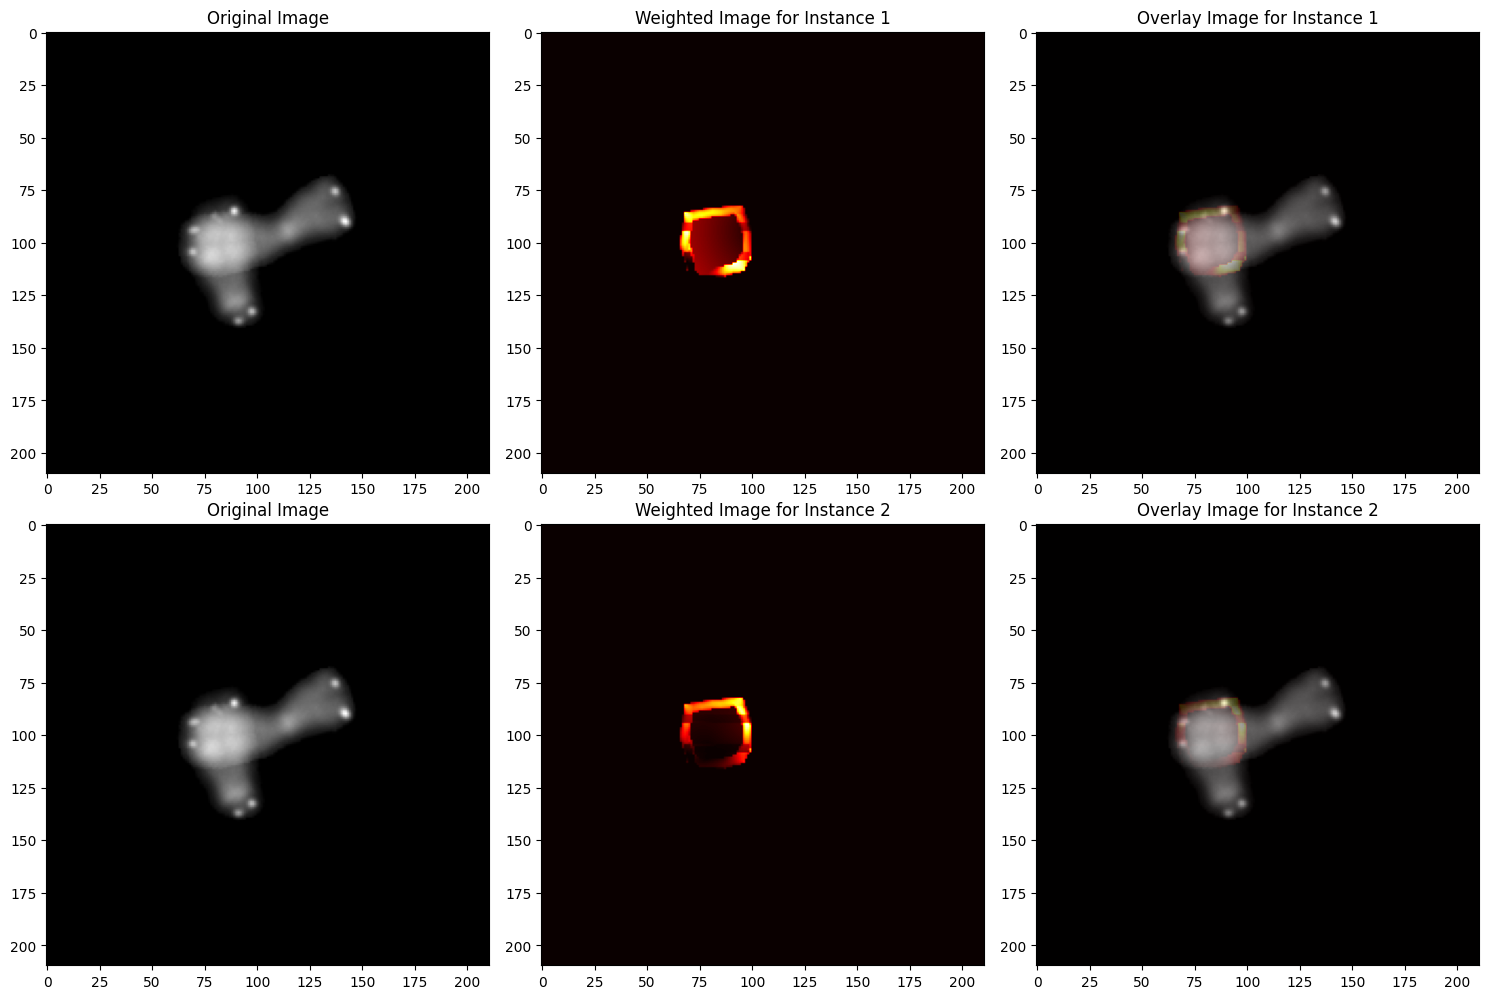

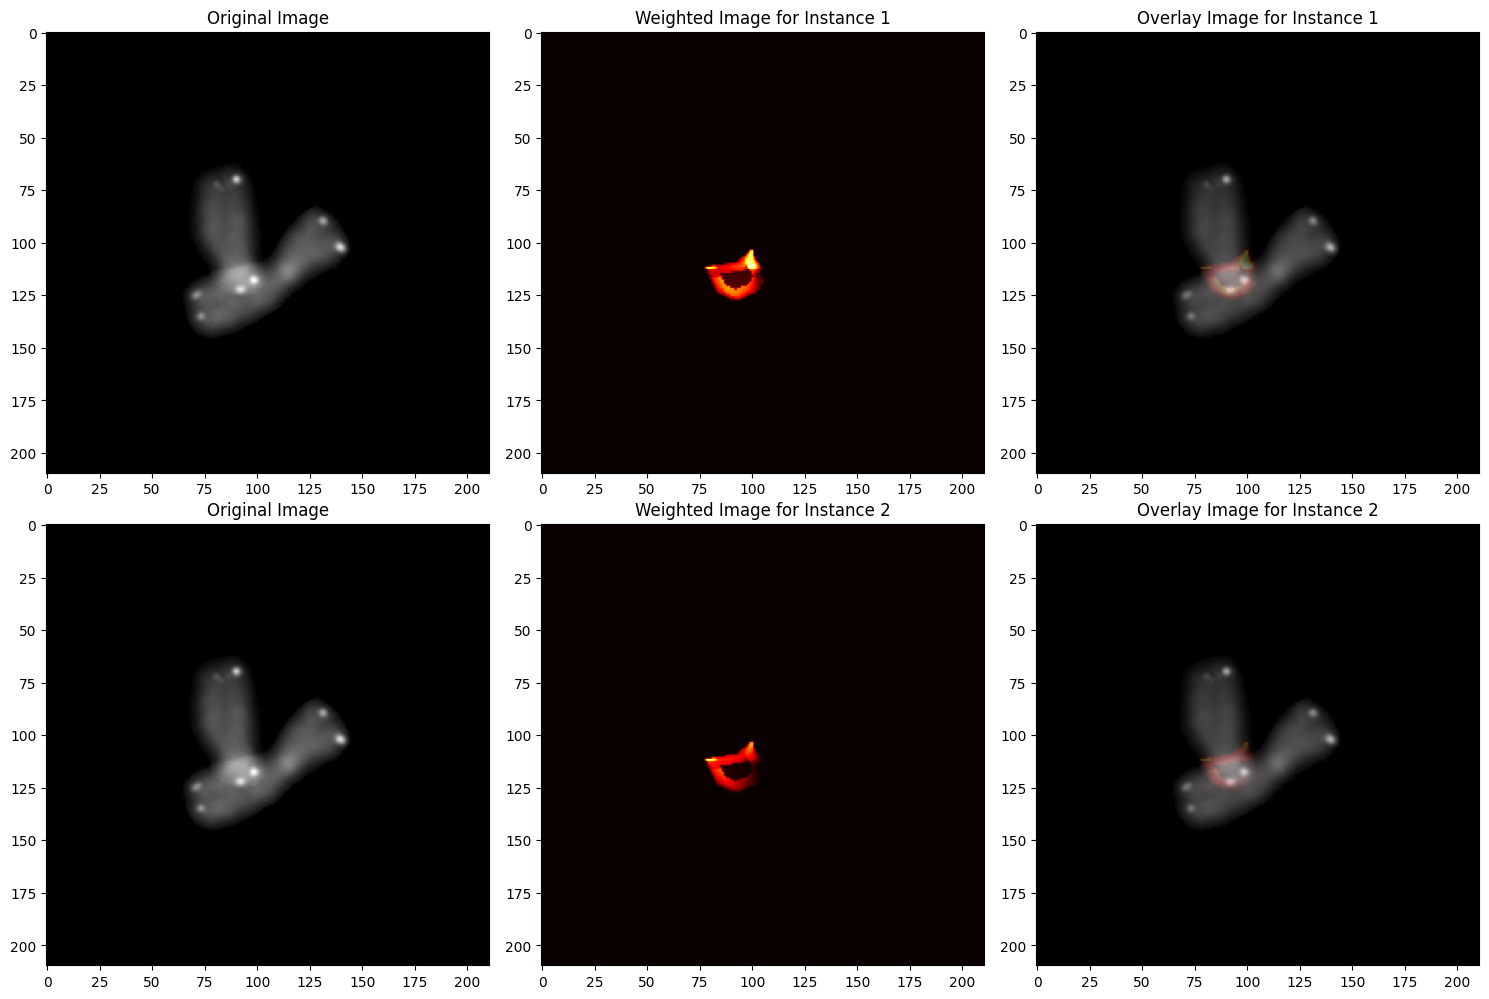

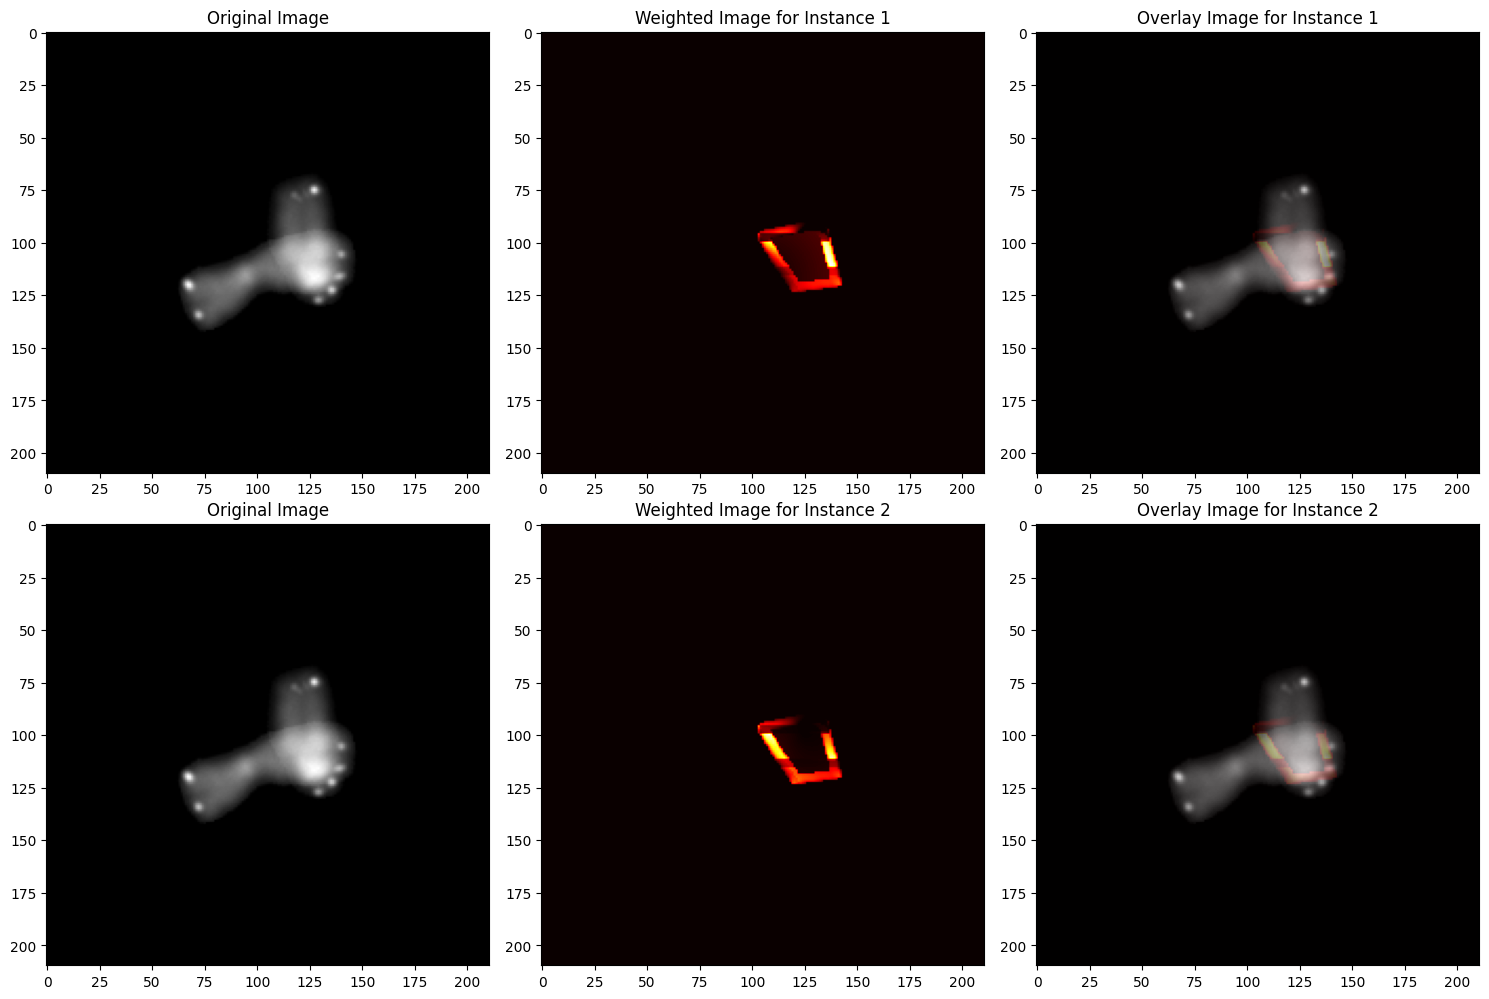

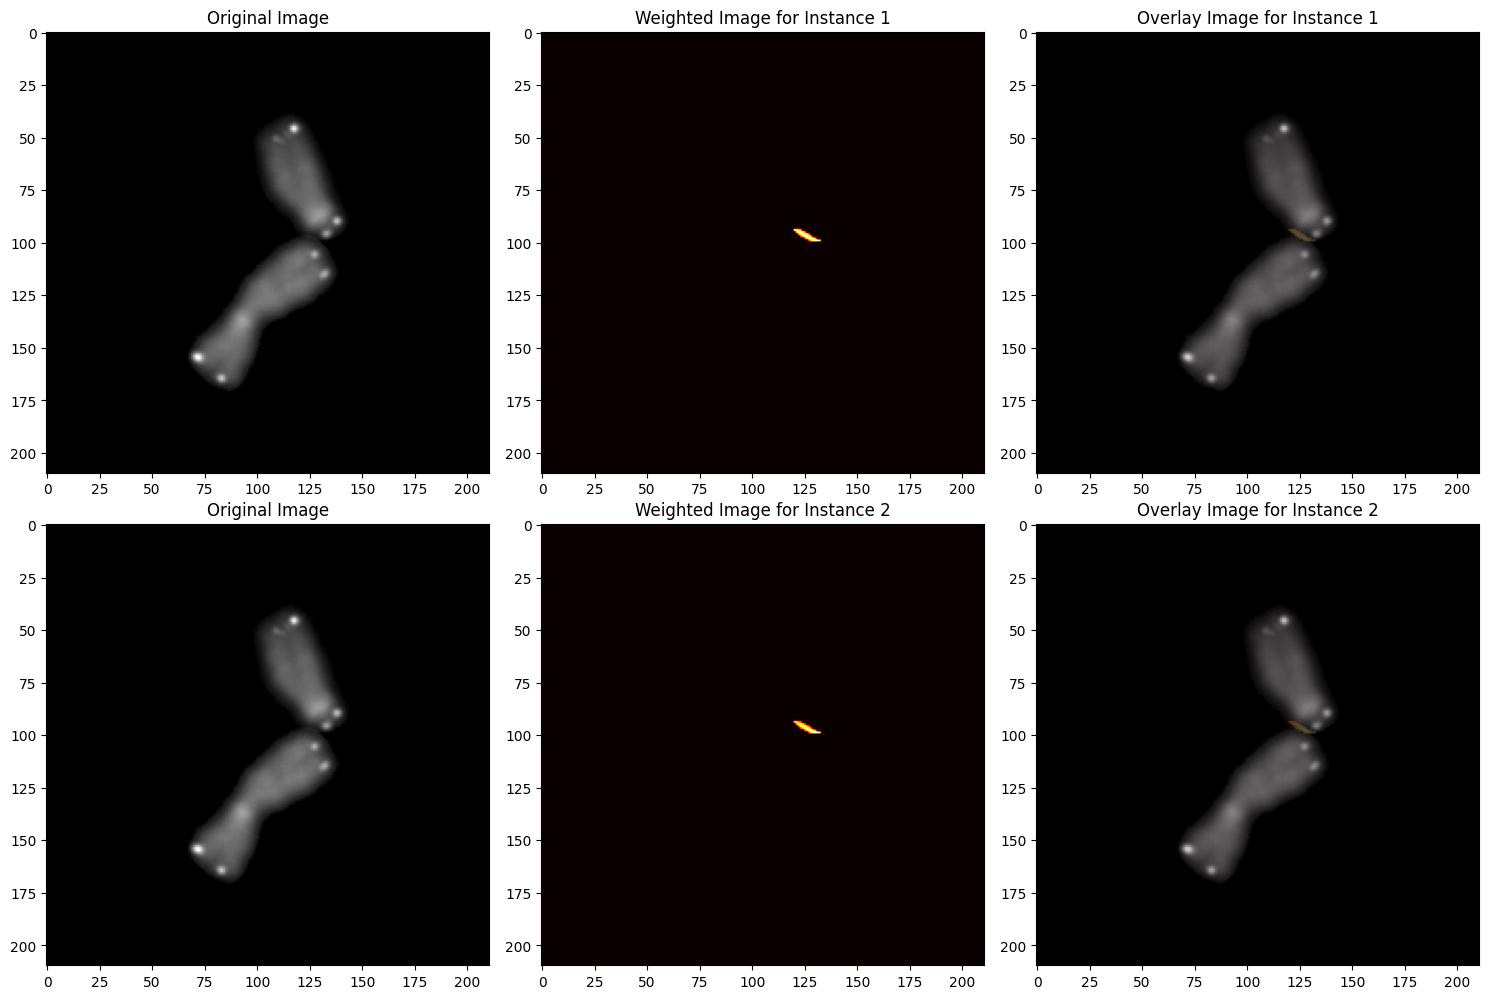

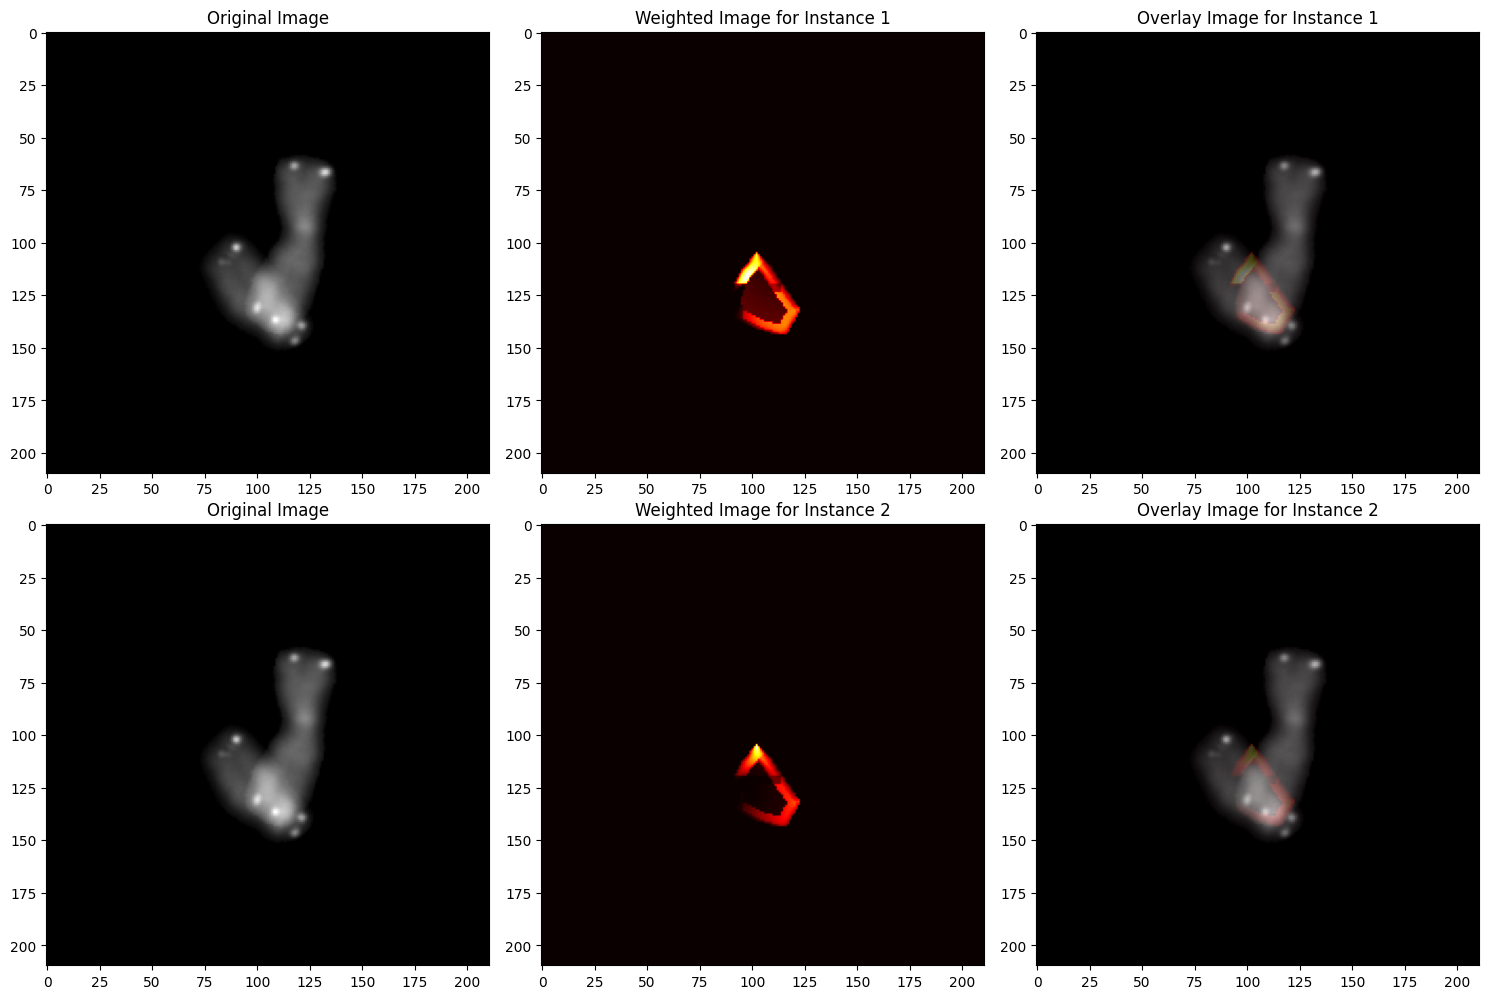

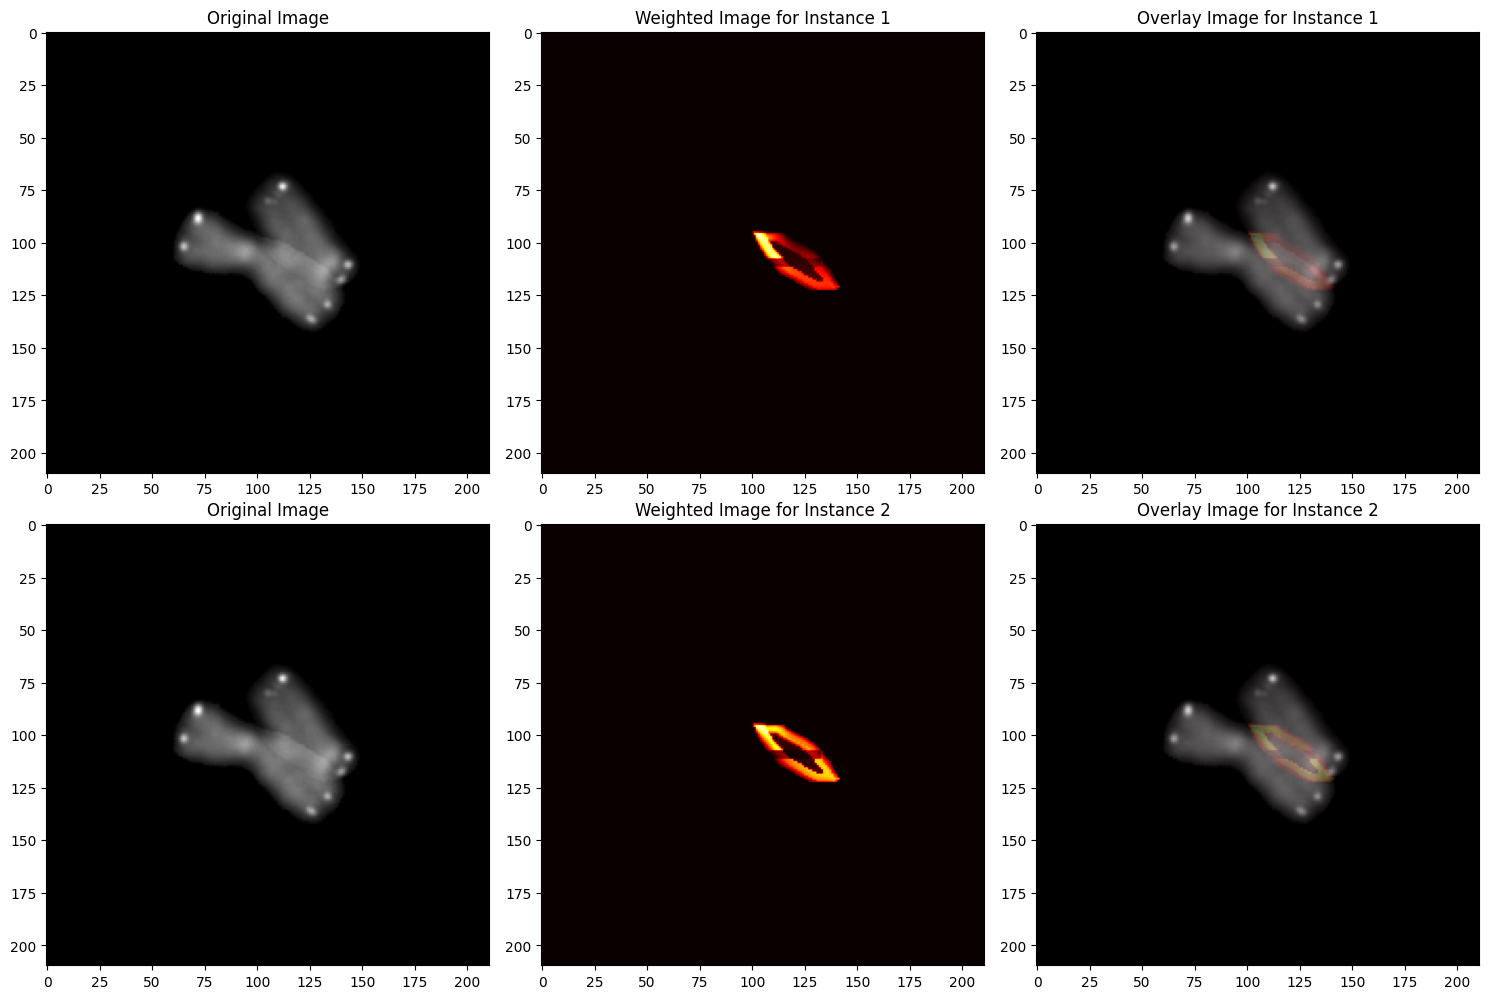

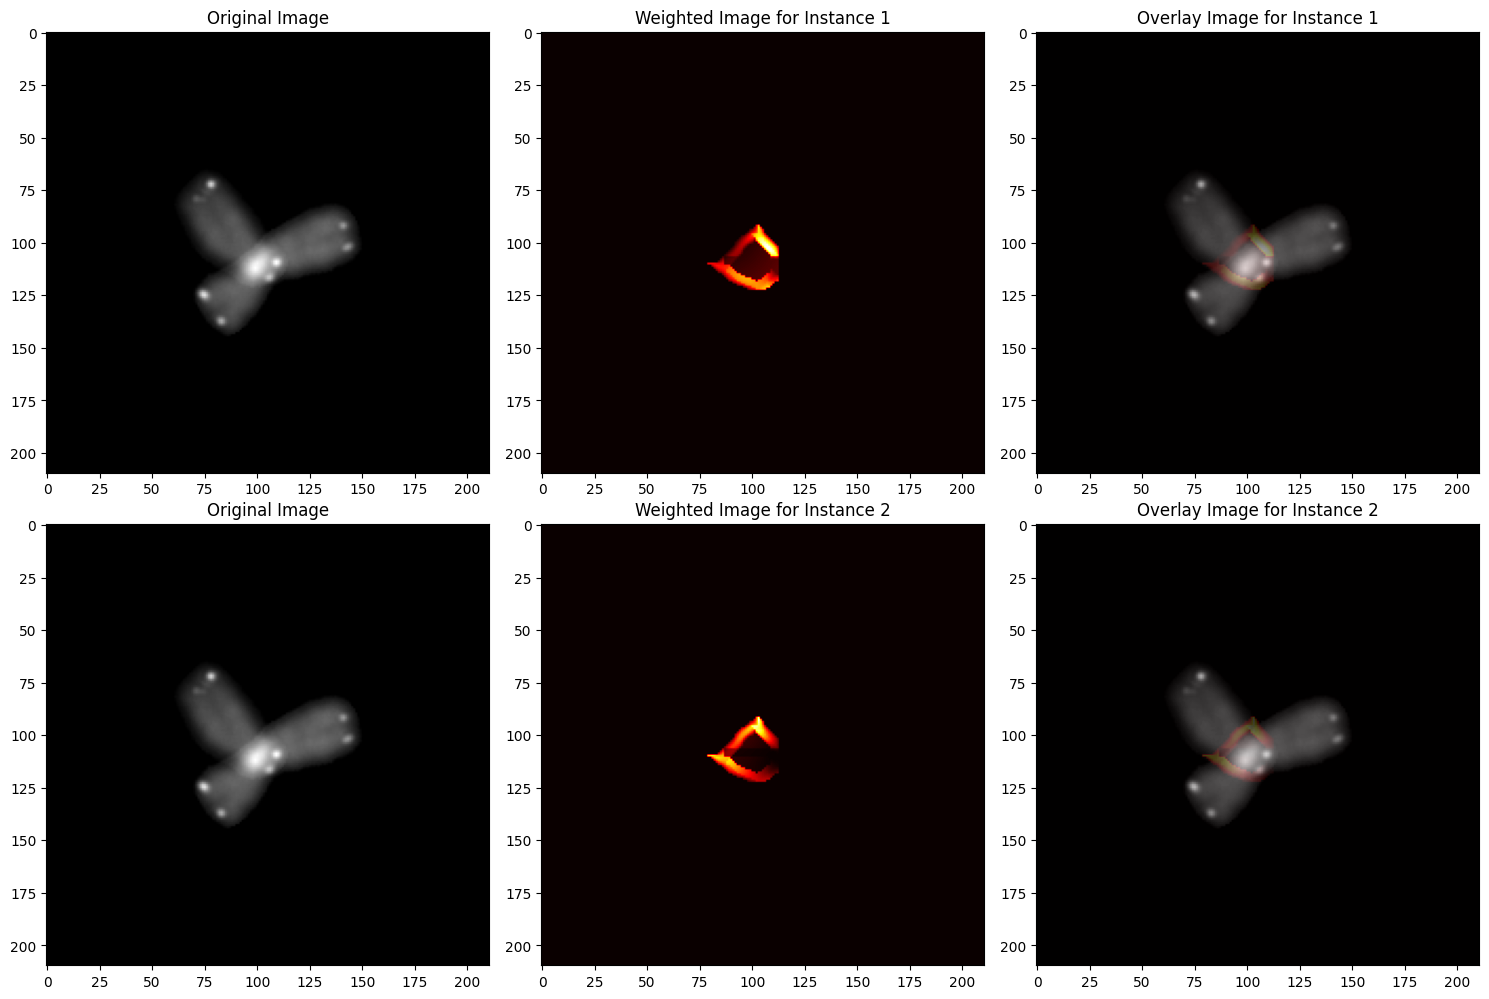

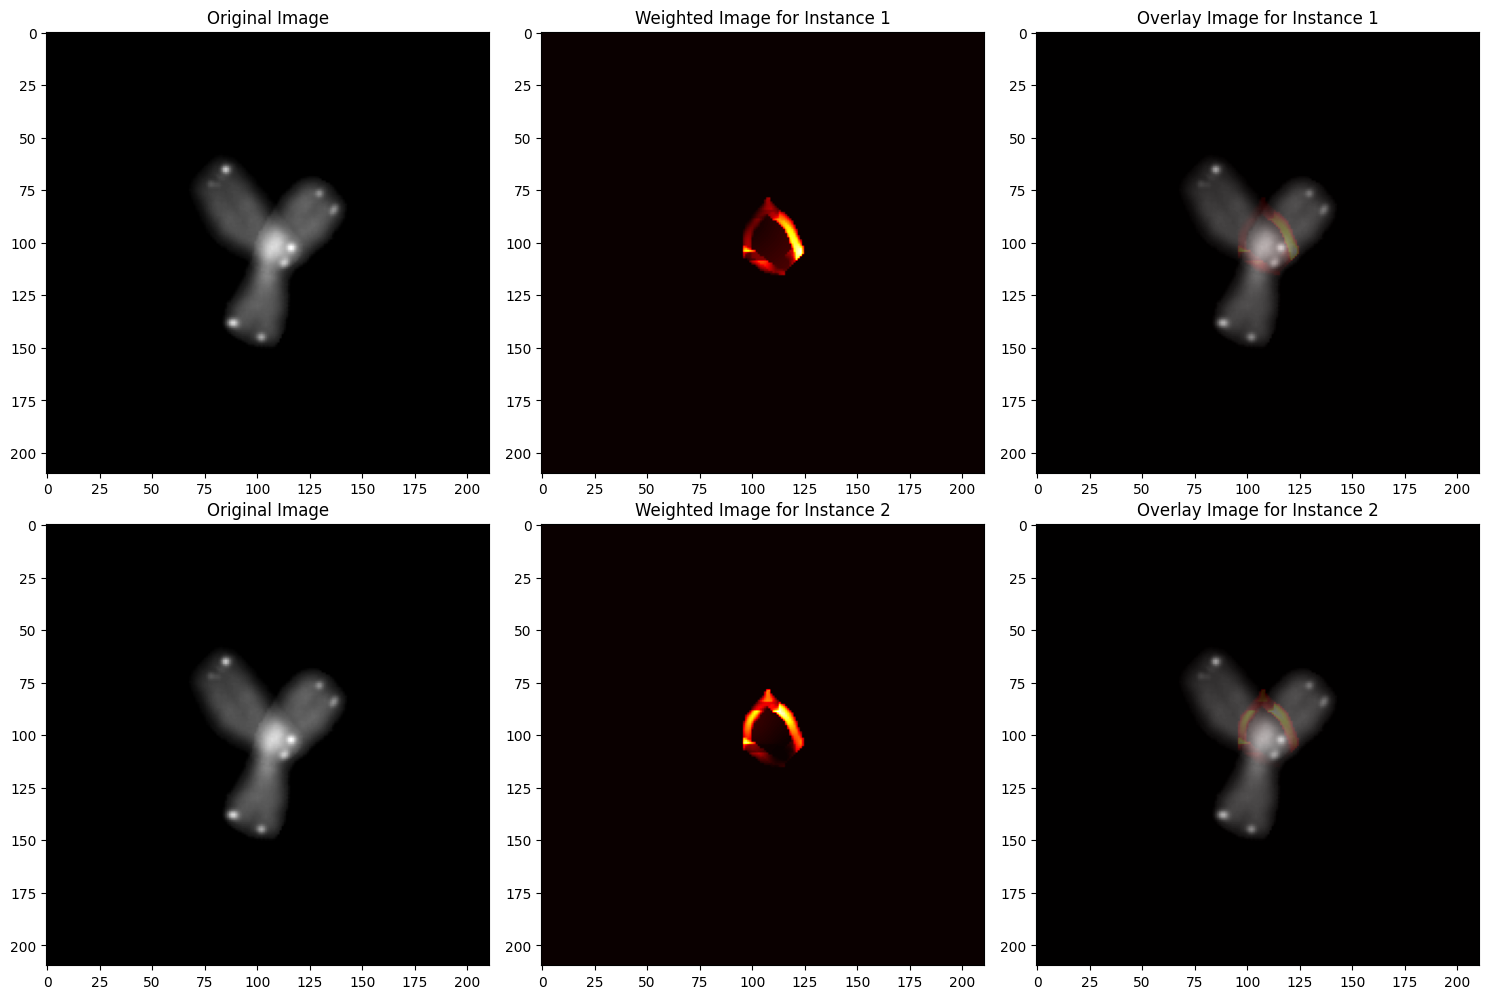

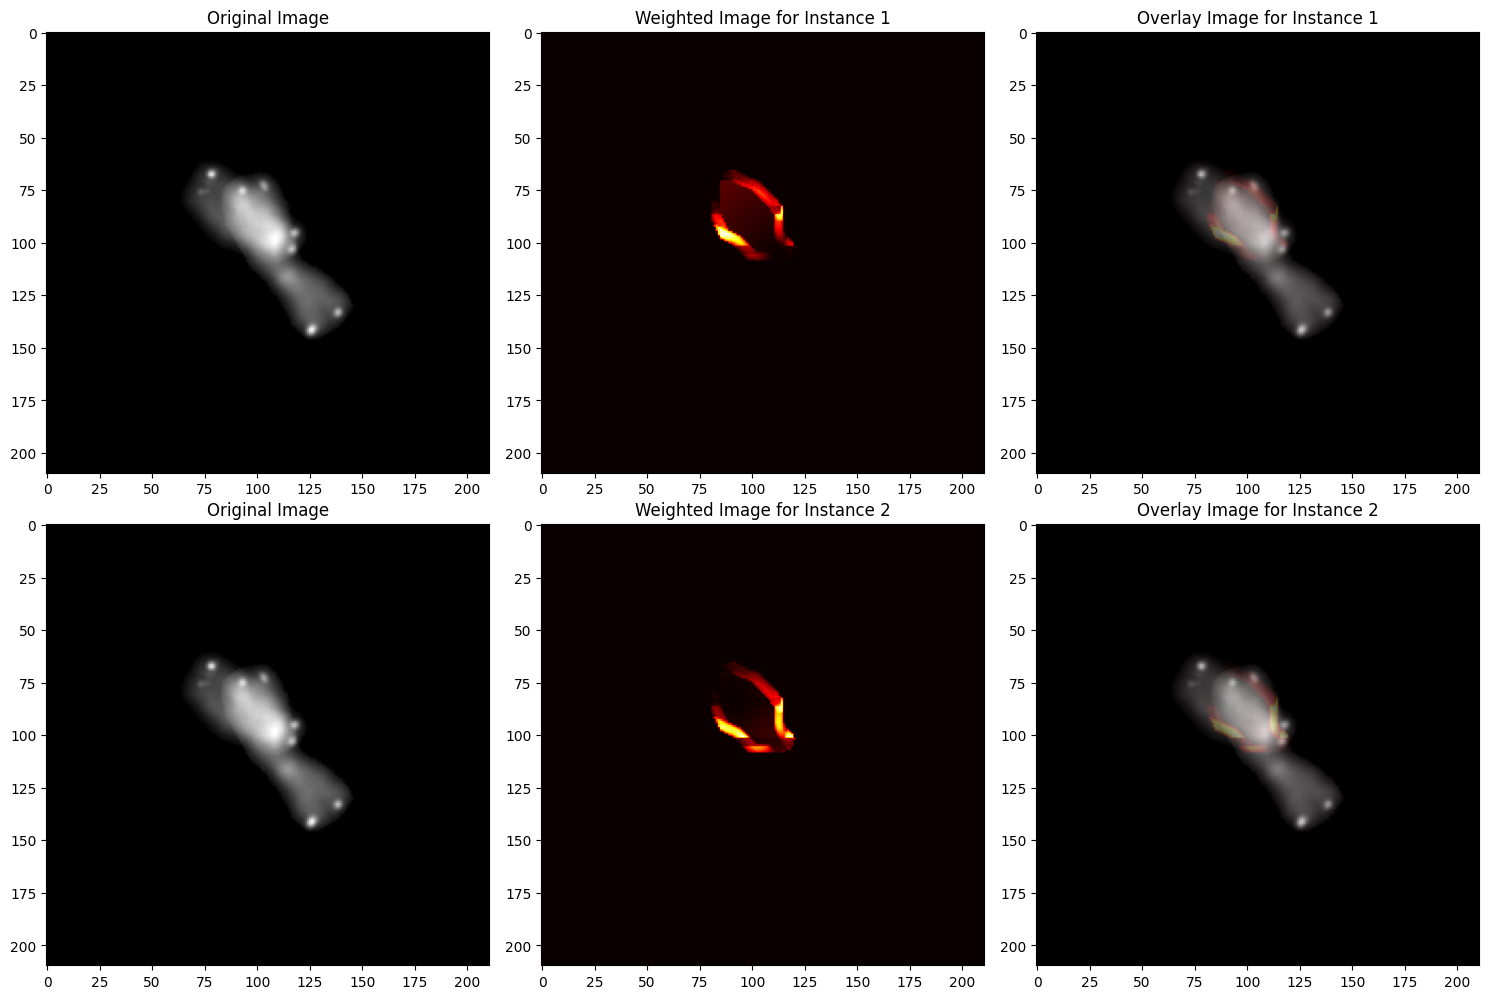

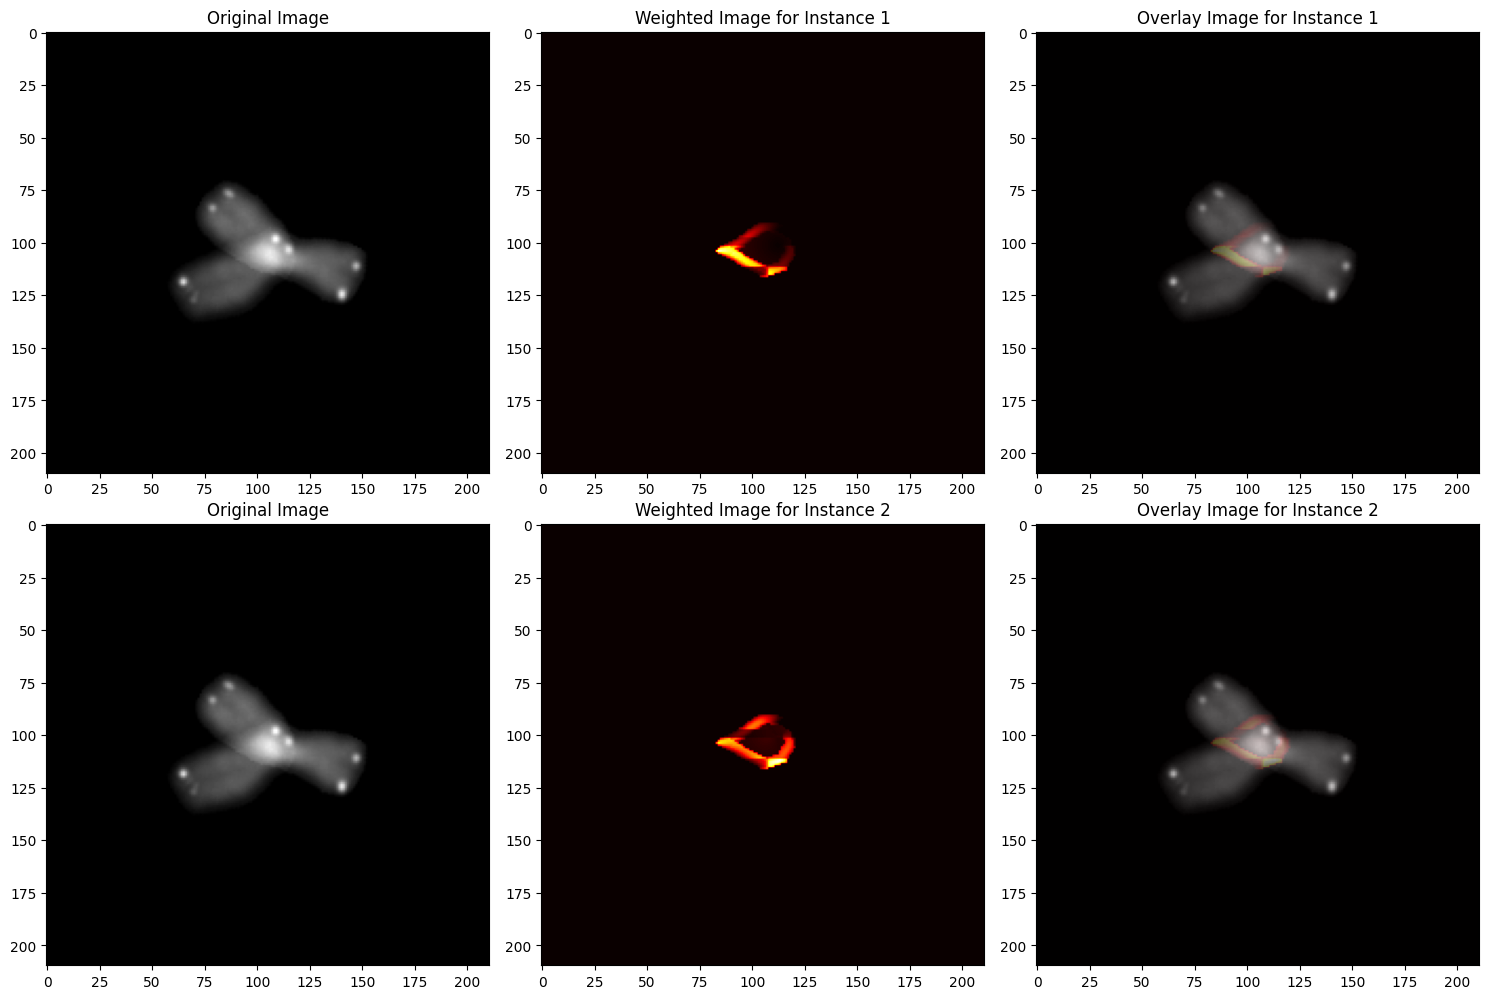

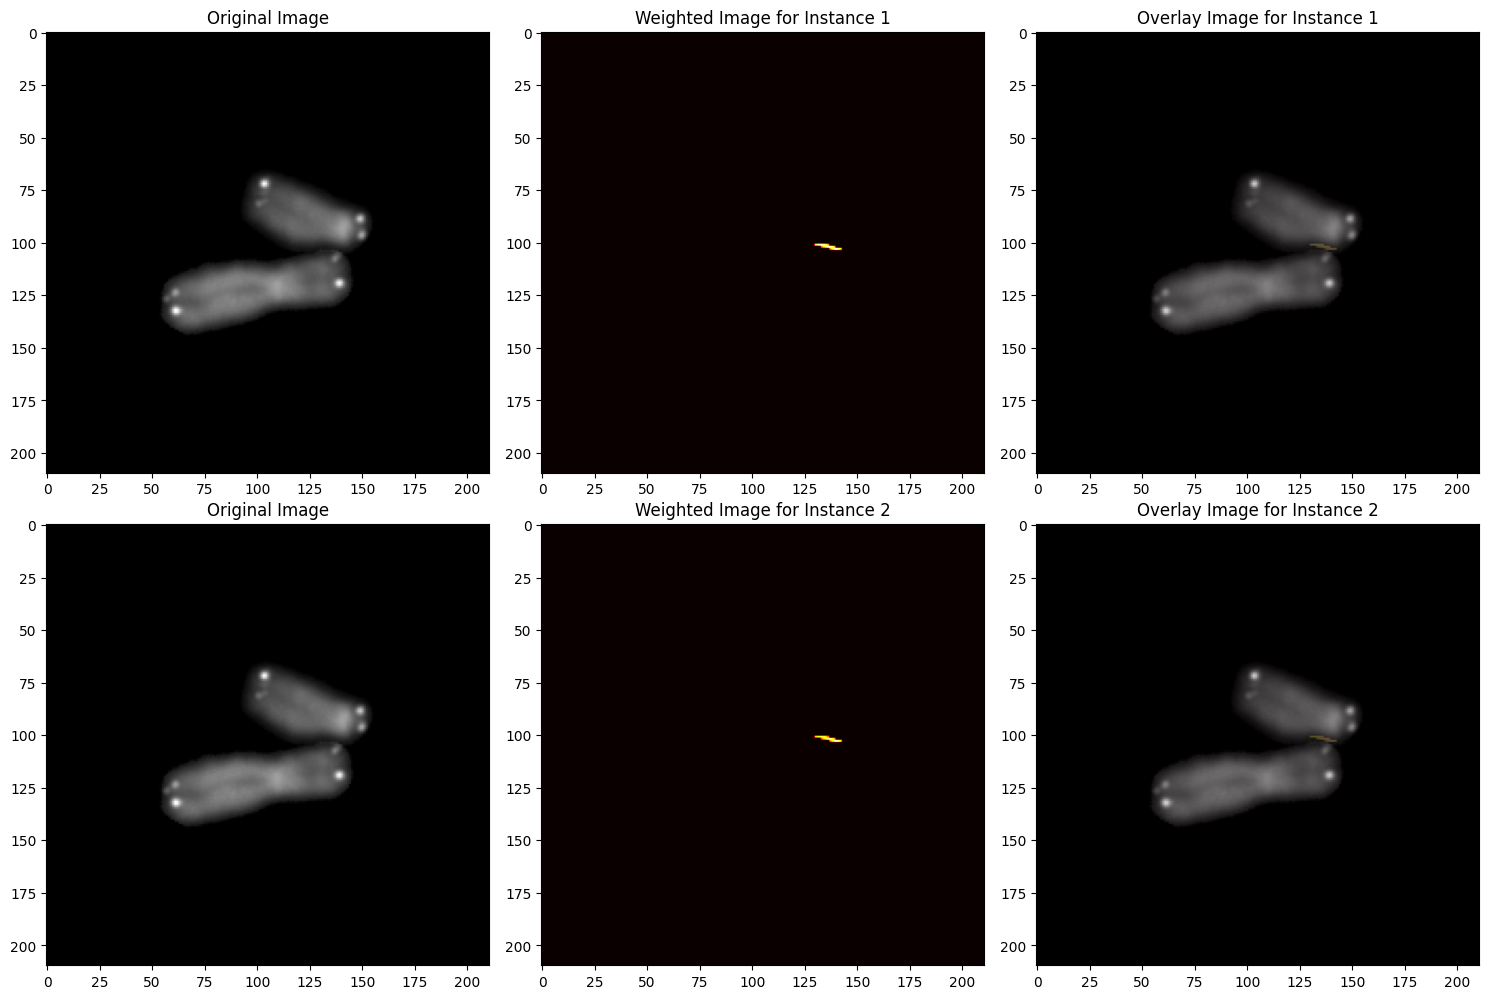

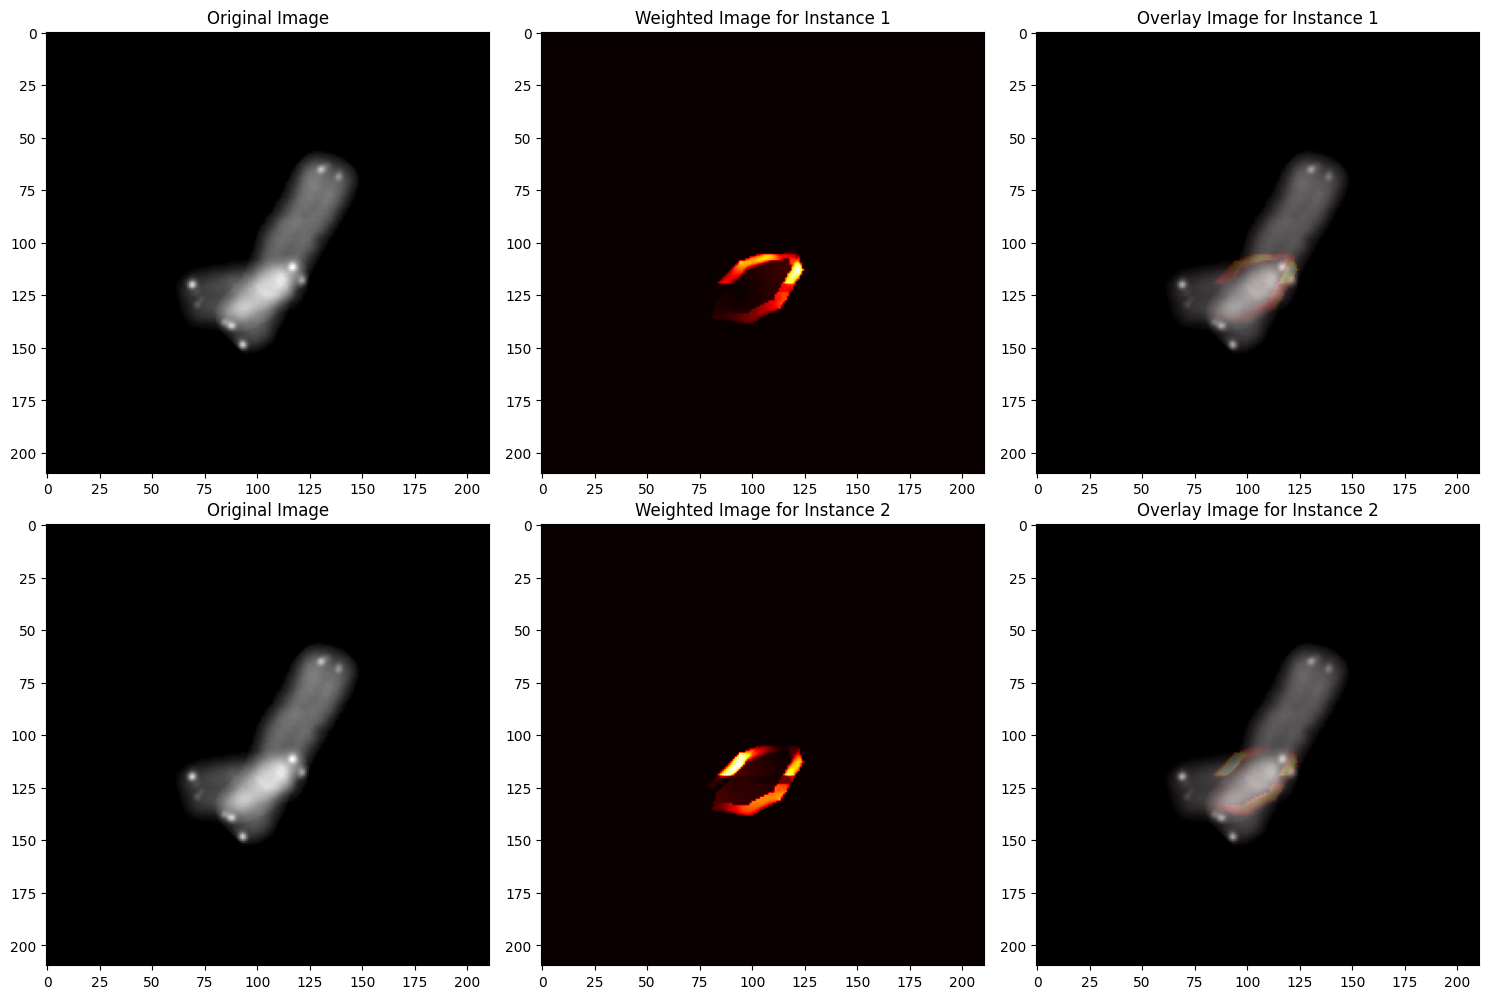

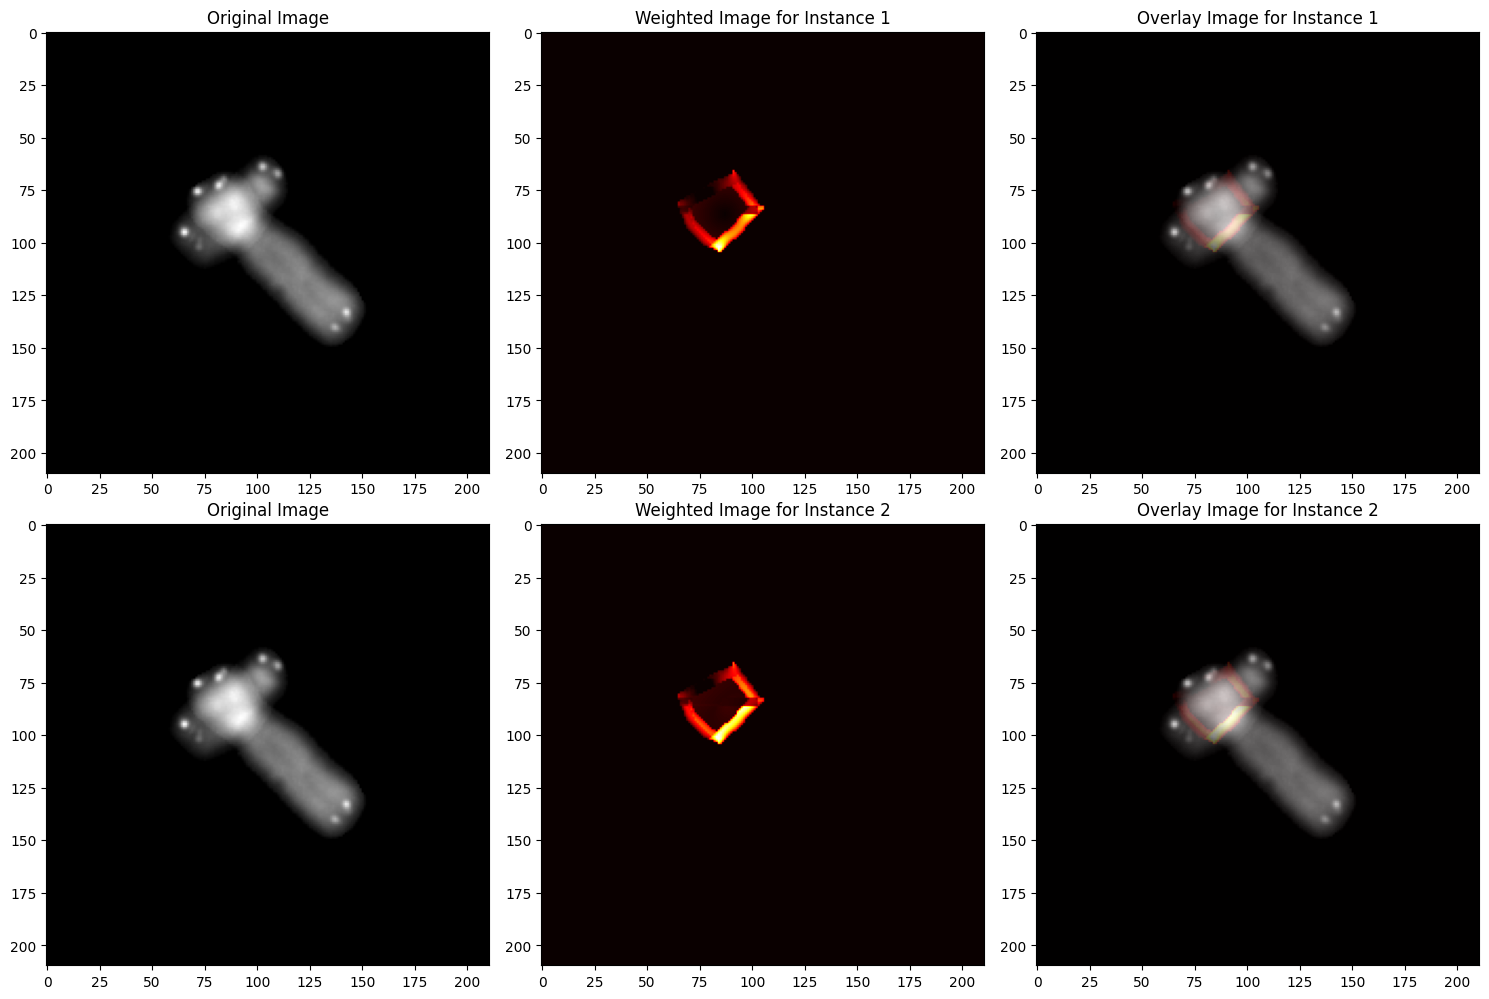

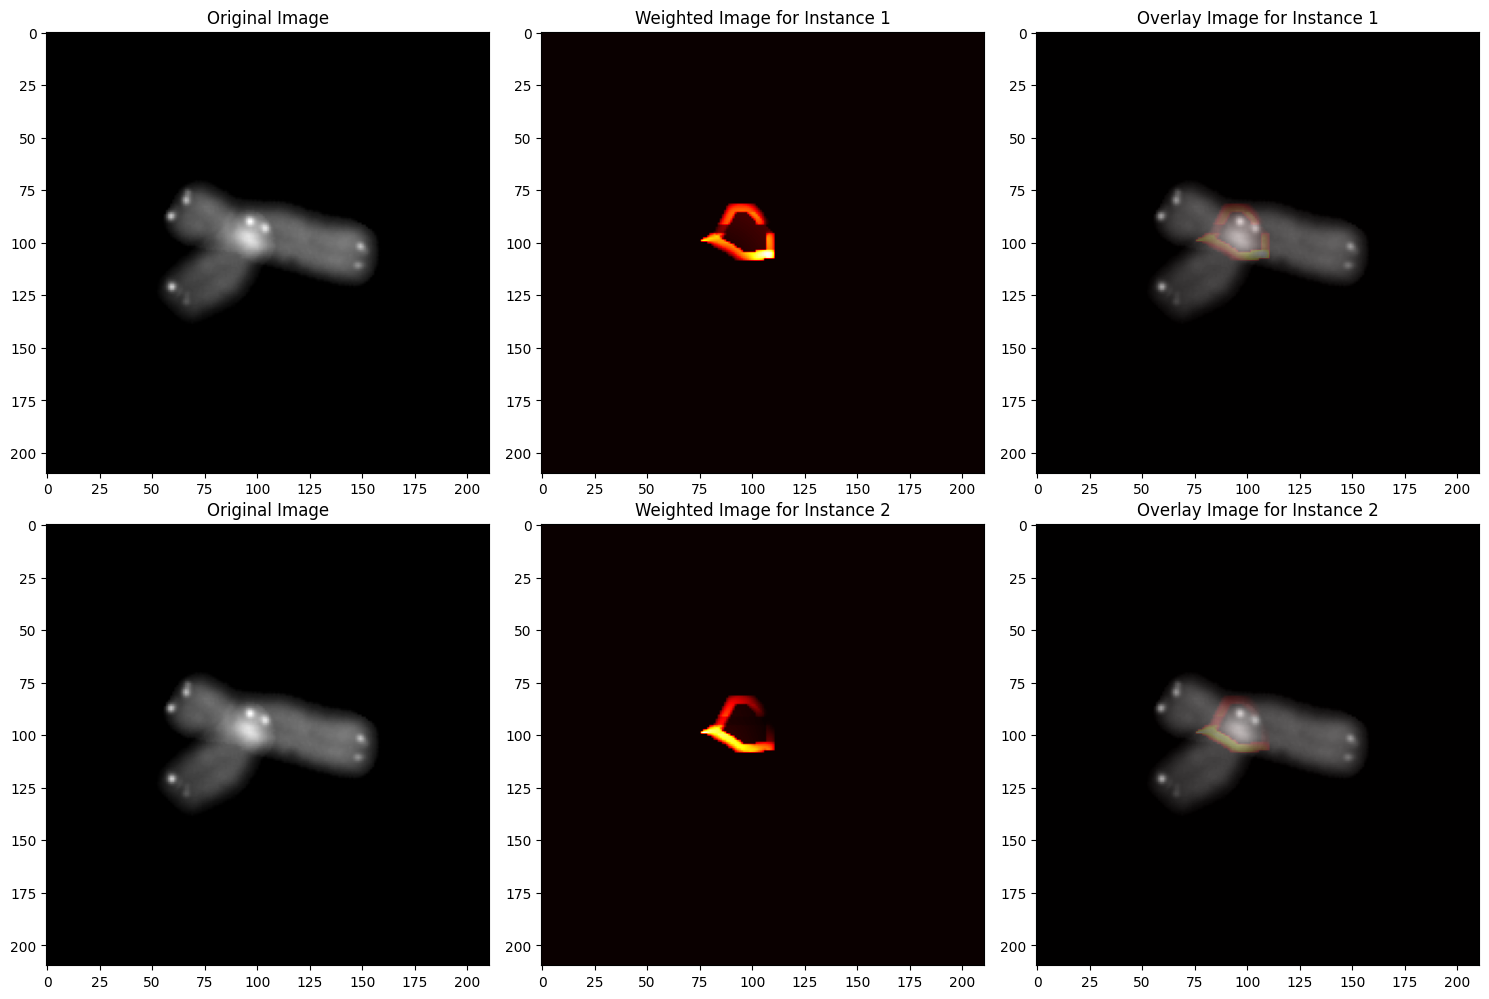

KeyboardInterrupt: 

In [10]:
json_data = json.load(open(training_json_path))
cmap = colors.LinearSegmentedColormap.from_list("mycmap", [(0,0,0,0), 'green', 'blue', 'red', 'yellow'])
def process_dataset(json_data):
  for image in json_data["images"]:
    image_info = {}
    image_info["image_name"] = image["file_name"]
    this_image = mpimg.imread(training_image_path + image_info["image_name"])
    instances_in_this_image = [i for i in json_data['annotations'] if i['image_id'] == image['id']]
    image_info["instances"] = instances_in_this_image
    image_info["instances_ids"] = [i['id'] for i in instances_in_this_image]
    image_info["instances_categories"] = [i["category_id"] for i in instances_in_this_image]
    image_info["num_instances"] = len(instances_in_this_image)
    image_info["image_shape"] = this_image.shape
    image_info["masks"] = find_masks(image_info["num_instances"], this_image, instances_in_this_image, image_info["image_shape"])
    image_info["grad_fields"] = find_grad_fields(image_info["masks"], 1)

    weighted_images_original_1 = find_GA_per_instance_original(image_info, window_size, target_category_id)
    weighted_images_inter_1 = find_GA_per_instance_inter(image_info, window_size, target_category_id, weighted_images_original_1)

    image_info["grad_fields"] = find_grad_fields(image_info["masks"], -1)
    weighted_images_original_2 = find_GA_per_instance_original(image_info, window_size, target_category_id)
    weighted_images_inter_2 = find_GA_per_instance_inter(image_info, window_size, target_category_id, weighted_images_original_2)

    weighted_images_inter = [(w1+w2)/2 for w1, w2 in zip(weighted_images_inter_1, weighted_images_inter_2)]

    show_weighted_images_per_instance(weighted_images_inter, this_image)

process_dataset(json_data)

